<a href="https://colab.research.google.com/github/Sadia81214/new/blob/master/Copy_of_autism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xgboost imbalanced-learn shap

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, roc_auc_score, recall_score
from sklearn.calibration import CalibratedClassifierCV
import shap
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
X_adult = pd.read_csv('/content/csv_data-Adult.csv')
X_child = pd.read_csv('/content/csv_data-Children.csv')


print("Adult Dataset Shape:", X_adult.shape)
print("Child Dataset Shape:", X_child.shape)
print("\nAdult Columns:", X_adult.columns.tolist())
print("\nChild Columns:", X_child.columns.tolist())
print("\nAdult Sample:\n", X_adult.head())
print("\nChild Sample:\n", X_child.head())
print("\nMissing Values in Adult:\n", X_adult.isnull().sum())
print("\nMissing Values in Child:\n", X_child.isnull().sum())

Adult Dataset Shape: (704, 22)
Child Dataset Shape: (292, 22)

Adult Columns: ['id', 'A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'used_app_before', 'result', 'age_desc', 'relation', 'Class/ASD']

Child Columns: ['id', 'A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'used_app_before', 'result', 'age_desc', 'relation', 'Class/ASD']

Adult Sample:
    id  A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  \
0   1         1         1         1         1         0         0         1   
1   2         1         1         0         1         0         0         0   
2   3         1         1         0         1         1         0         1   
3   4         1         1         0         1     

In [3]:
def preprocess_df(df, dataset_name=''):
    df = df.copy()

    drop_cols = ['id', 'used_app_before', 'age_desc']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])

    cat_cols = ['ethnicity', 'relation']
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].replace('?', 'Unknown')


    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df['age'] = df['age'].fillna(df['age'].median())


    le = LabelEncoder()
    encode_cols = ['gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'relation']
    for col in encode_cols:
        if col in df.columns:
            df[col] = le.fit_transform(df[col].astype(str))


    if 'Class/ASD' in df.columns:
        df['Class/ASD'] = df['Class/ASD'].map({'YES': 1, 'NO': 0})


    X = df.drop('Class/ASD', axis=1)
    y = df['Class/ASD']


    scaler = StandardScaler()
    num_cols = ['age', 'result']
    if all(col in X.columns for col in num_cols):
        X[num_cols] = scaler.fit_transform(X[num_cols])


    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)


    print(f"\n{dataset_name} Preprocessed Shape:", X_res.shape)
    print(f"{dataset_name} Class Balance:\n", y_res.value_counts())
    print(f"{dataset_name} Missing Values:\n", X_res.isnull().sum().to_string())

    return X_res, y_res


X_adult = pd.read_csv('/content/csv_data-Adult.csv')
X_child = pd.read_csv('/content/csv_data-Children.csv')

X_adult_proc, y_adult = preprocess_df(X_adult, 'Adult')
X_child_proc, y_child = preprocess_df(X_child, 'Child')


Adult Preprocessed Shape: (1030, 18)
Adult Class Balance:
 Class/ASD
0    515
1    515
Name: count, dtype: int64
Adult Missing Values:
 A1_Score         0
A2_Score         0
A3_Score         0
A4_Score         0
A5_Score         0
A6_Score         0
A7_Score         0
A8_Score         0
A9_Score         0
A10_Score        0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
result           0
relation         0

Child Preprocessed Shape: (302, 18)
Child Class Balance:
 Class/ASD
0    151
1    151
Name: count, dtype: int64
Child Missing Values:
 A1_Score         0
A2_Score         0
A3_Score         0
A4_Score         0
A5_Score         0
A6_Score         0
A7_Score         0
A8_Score         0
A9_Score         0
A10_Score        0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
result           0
relation         0


In [4]:
X_adult_proc.to_csv('Adult_preprocessed.csv', index=False)
y_adult.to_csv('Adult_labels.csv', index=False)
X_child_proc.to_csv('Child_preprocessed.csv', index=False)
y_child.to_csv('Child_labels.csv', index=False)

In [5]:

X_adult_proc = pd.read_csv('Adult_preprocessed.csv')
y_adult = pd.read_csv('Adult_labels.csv')
X_child_proc = pd.read_csv('Child_preprocessed.csv')
y_child = pd.read_csv('Child_labels.csv')


print("Adult Preprocessed Shape:", X_adult_proc.shape)
print("\nAdult Preprocessed Sample:\n", X_adult_proc.head(5).to_string())
print("\nAdult Labels Sample:\n", y_adult.head(5).to_string())
print("\nChild Preprocessed Shape:", X_child_proc.shape)
print("\nChild Preprocessed Sample:\n", X_child_proc.head(5).to_string())
print("\nChild Labels Sample:\n", y_child.head(5).to_string())

Adult Preprocessed Shape: (1030, 18)

Adult Preprocessed Sample:
    A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  A6_Score  A7_Score  A8_Score  A9_Score  A10_Score       age  gender  ethnicity  jundice  austim  contry_of_res    result  relation
0         1         1         1         1         0         0         1         1         0          0 -0.224025       0         10        0       0             64  0.450051         4
1         1         1         0         1         0         0         0         1         0          1 -0.345437       1          3        0       1             13  0.050006         4
2         1         1         0         1         1         0         1         1         1          1 -0.163319       1          3        1       1             56  1.250142         2
3         1         1         0         1         0         0         1         1         0          1  0.322327       0         10        0       1             64  0.450051         4
4         1   

In [6]:

X_adult_proc = pd.read_csv('Adult_preprocessed.csv')
y_adult = pd.read_csv('Adult_labels.csv')
X_child_proc = pd.read_csv('Child_preprocessed.csv')
y_child = pd.read_csv('Child_labels.csv')


y_adult = y_adult['Class/ASD'] if 'Class/ASD' in y_adult.columns else y_adult.values.ravel()
y_child = y_child['Class/ASD'] if 'Class/ASD' in y_child.columns else y_child.values.ravel()


print("Adult Preprocessed Shape:", X_adult_proc.shape, y_adult.shape)
print("Child Preprocessed Shape:", X_child_proc.shape, y_child.shape)


print("\nAdult Age Range: Min=", X_adult_proc['age'].min(), "Max=", X_adult_proc['age'].max())
print("Child Age Range: Min=", X_child_proc['age'].min(), "Max=", X_child_proc['age'].max())


def get_mapping(df, col, original_df):
    le = LabelEncoder()
    le.fit(original_df[col].replace('?', 'Unknown').astype(str))
    return dict(zip(le.classes_, le.transform(le.classes_)))


X_adult_orig = pd.read_csv('/content/csv_data-Adult.csv')
X_child_orig = pd.read_csv('/content/csv_data-Children.csv')


adult_ethnicity_map = get_mapping(X_adult_proc, 'ethnicity', X_adult_orig)
child_ethnicity_map = get_mapping(X_child_proc, 'ethnicity', X_child_orig)
print("\nAdult Ethnicity Mapping:", adult_ethnicity_map)
print("Child Ethnicity Mapping:", child_ethnicity_map)



Adult Preprocessed Shape: (1030, 18) (1030,)
Child Preprocessed Shape: (302, 18) (302,)

Adult Age Range: Min= -0.7703777339957056 Max= 21.447957664736048
Child Age Range: Min= -1.0016359789739648 Max= 1.9828304073566243

Adult Ethnicity Mapping: {'Asian': np.int64(0), 'Black': np.int64(1), 'Hispanic': np.int64(2), 'Latino': np.int64(3), 'Middle Eastern ': np.int64(4), 'Others': np.int64(5), 'Pasifika': np.int64(6), 'South Asian': np.int64(7), 'Turkish': np.int64(8), 'Unknown': np.int64(9), 'White-European': np.int64(10), 'others': np.int64(11)}
Child Ethnicity Mapping: {'Asian': np.int64(0), 'Black': np.int64(1), 'Hispanic': np.int64(2), 'Latino': np.int64(3), 'Middle Eastern ': np.int64(4), 'Others': np.int64(5), 'Pasifika': np.int64(6), 'South Asian': np.int64(7), 'Turkish': np.int64(8), 'Unknown': np.int64(9), 'White-European': np.int64(10)}


In [7]:
y_adult = y_adult.values.ravel()
y_child = y_child.values.ravel()


def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)
specificity = make_scorer(specificity_score)


models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}


def evaluate_within(X, y, name):
    results = []
    for m_name, model in models.items():
        cv_results = cross_validate(model, X, y, cv=5, scoring={'auroc': 'roc_auc', 'sensitivity': 'recall', 'specificity': specificity})
        results.append({
            'Model': m_name,
            'Dataset': name,
            'AUROC': np.mean(cv_results['test_auroc']),
            'Sensitivity': np.mean(cv_results['test_sensitivity']),
            'Specificity': np.mean(cv_results['test_specificity'])
        })
    return pd.DataFrame(results)


within_adult = evaluate_within(X_adult_proc, y_adult, 'Adult')
within_child = evaluate_within(X_child_proc, y_child, 'Child')


results = pd.concat([within_adult, within_child])
print("Within-Dataset Results:\n", results)
results.to_csv('within_dataset_results.csv', index=False)
print("\nResults saved to 'within_dataset_results.csv'")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Within-Dataset Results:
                  Model Dataset     AUROC  Sensitivity  Specificity
0  Logistic Regression   Adult  1.000000     1.000000     0.996117
1        Random Forest   Adult  1.000000     1.000000     1.000000
2              XGBoost   Adult  1.000000     1.000000     1.000000
0  Logistic Regression   Child  0.999778     0.993333     0.993333
1        Random Forest   Child  1.000000     1.000000     1.000000
2              XGBoost   Child  1.000000     1.000000     1.000000

Results saved to 'within_dataset_results.csv'


In [8]:
X_adult_no_result = X_adult_proc.drop(columns=['result'], errors='ignore')
X_child_no_result = X_child_proc.drop(columns=['result'], errors='ignore')


def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)


models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}


cross_results = []
for m_name, model in models.items():
    # Train on Adult, test on Child
    model.fit(X_adult_no_result, y_adult)
    proba = model.predict_proba(X_child_no_result)[:, 1]
    preds = model.predict(X_child_no_result)
    cross_results.append({
        'Model': m_name,
        'Train': 'Adult',
        'Test': 'Child',
        'AUROC': roc_auc_score(y_child, proba),
        'Sensitivity': recall_score(y_child, preds),
        'Specificity': specificity_score(y_child, preds)
    })

    # Train on Child, test on Adult
    model.fit(X_child_no_result, y_child)
    proba = model.predict_proba(X_adult_no_result)[:, 1]
    preds = model.predict(X_adult_no_result)
    cross_results.append({
        'Model': m_name,
        'Train': 'Child',
        'Test': 'Adult',
        'AUROC': roc_auc_score(y_adult, proba),
        'Sensitivity': recall_score(y_adult, preds),
        'Specificity': specificity_score(y_adult, preds)
    })

cross_df = pd.DataFrame(cross_results)
print("Cross-Dataset Results (without result column):\n", cross_df)

# Generalization gap (using within-dataset results for comparison)
within_results = pd.read_csv('within_dataset_results.csv')
gap = cross_df.groupby('Model')['AUROC'].mean() - within_results.groupby('Model')['AUROC'].mean()
print("\nGeneralization Gap (lower better):\n", gap)

# Save results
cross_df.to_csv('cross_dataset_results.csv', index=False)
print("\nResults saved to 'cross_dataset_results.csv'")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Cross-Dataset Results (without result column):
                  Model  Train   Test     AUROC  Sensitivity  Specificity
0  Logistic Regression  Adult  Child  0.993772     0.993377     0.887417
1  Logistic Regression  Child  Adult  0.983052     0.873786     0.947573
2        Random Forest  Adult  Child  0.956011     0.874172     0.854305
3        Random Forest  Child  Adult  0.969835     0.817476     0.949515
4              XGBoost  Adult  Child  0.956449     0.907285     0.841060
5              XGBoost  Child  Adult  0.969153     0.864078     0.920388

Generalization Gap (lower better):
 Model
Logistic Regression   -0.011477
Random Forest         -0.037077
XGBoost               -0.037199
Name: AUROC, dtype: float64

Results saved to 'cross_dataset_results.csv'


In [9]:

demographic_cols = ['age', 'gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'relation']
X_adult_demo = X_adult_proc[demographic_cols]
X_child_demo = X_child_proc[demographic_cols]


def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)

# Models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Cross-dataset evaluation
cross_results = []
for m_name, model in models.items():
    # Train on Adult, test on Child
    model.fit(X_adult_demo, y_adult)
    proba = model.predict_proba(X_child_demo)[:, 1]
    preds = model.predict(X_child_demo)
    cross_results.append({
        'Model': m_name,
        'Train': 'Adult',
        'Test': 'Child',
        'AUROC': roc_auc_score(y_child, proba),
        'Sensitivity': recall_score(y_child, preds),
        'Specificity': specificity_score(y_child, preds)
    })

    # Train on Child, test on Adult
    model.fit(X_child_demo, y_child)
    proba = model.predict_proba(X_adult_demo)[:, 1]
    preds = model.predict(X_adult_demo)
    cross_results.append({
        'Model': m_name,
        'Train': 'Child',
        'Test': 'Adult',
        'AUROC': roc_auc_score(y_adult, proba),
        'Sensitivity': recall_score(y_adult, preds),
        'Specificity': specificity_score(y_adult, preds)
    })

cross_df = pd.DataFrame(cross_results)
print("Cross-Dataset Results (Demographic Features Only):\n", cross_df)

# Generalization gap (using your within-dataset results)
within_results = pd.read_csv('within_dataset_results.csv')
gap = cross_df.groupby('Model')['AUROC'].mean() - within_results.groupby('Model')['AUROC'].mean()
print("\nGeneralization Gap (lower better):\n", gap)

# Save results
cross_df.to_csv('cross_dataset_demo_results.csv', index=False)
print("\nResults saved to 'cross_dataset_demo_results.csv'")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Cross-Dataset Results (Demographic Features Only):
                  Model  Train   Test     AUROC  Sensitivity  Specificity
0  Logistic Regression  Adult  Child  0.563352     0.874172     0.158940
1  Logistic Regression  Child  Adult  0.583623     0.027184     0.974757
2        Random Forest  Adult  Child  0.503224     0.251656     0.735099
3        Random Forest  Child  Adult  0.586713     0.328155     0.813592
4              XGBoost  Adult  Child  0.510372     0.370861     0.642384
5              XGBoost  Child  Adult  0.504302     0.357282     0.652427

Generalization Gap (lower better):
 Model
Logistic Regression   -0.426401
Random Forest         -0.455032
XGBoost               -0.492663
Name: AUROC, dtype: float64

Results saved to 'cross_dataset_demo_results.csv'


In [10]:

X_adult_no_result = X_adult_proc.drop(columns=['result'], errors='ignore')
X_child_no_result = X_child_proc.drop(columns=['result'], errors='ignore')


def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)


models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Cross-dataset evaluation
cross_results = []
for m_name, model in models.items():
    # Train on Adult, test on Child
    model.fit(X_adult_no_result, y_adult)
    proba = model.predict_proba(X_child_no_result)[:, 1]
    preds = model.predict(X_child_no_result)
    cross_results.append({
        'Model': m_name,
        'Train': 'Adult',
        'Test': 'Child',
        'AUROC': roc_auc_score(y_child, proba),
        'Sensitivity': recall_score(y_child, preds),
        'Specificity': specificity_score(y_child, preds)
    })

    # Train on Child, test on Adult
    model.fit(X_child_no_result, y_child)
    proba = model.predict_proba(X_adult_no_result)[:, 1]
    preds = model.predict(X_adult_no_result)
    cross_results.append({
        'Model': m_name,
        'Train': 'Child',
        'Test': 'Adult',
        'AUROC': roc_auc_score(y_adult, proba),
        'Sensitivity': recall_score(y_adult, preds),
        'Specificity': specificity_score(y_adult, preds)
    })

cross_df = pd.DataFrame(cross_results)
print("Cross-Dataset Results (All Features Except result):\n", cross_df)

# Generalization gap
within_results = pd.read_csv('within_dataset_results.csv')
gap = cross_df.groupby('Model')['AUROC'].mean() - within_results.groupby('Model')['AUROC'].mean()
print("\nGeneralization Gap (lower better):\n", gap)

# Save results
cross_df.to_csv('cross_dataset_all_features_results.csv', index=False)
print("\nResults saved to 'cross_dataset_all_features_results.csv'")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Cross-Dataset Results (All Features Except result):
                  Model  Train   Test     AUROC  Sensitivity  Specificity
0  Logistic Regression  Adult  Child  0.993772     0.993377     0.887417
1  Logistic Regression  Child  Adult  0.983052     0.873786     0.947573
2        Random Forest  Adult  Child  0.956011     0.874172     0.854305
3        Random Forest  Child  Adult  0.969835     0.817476     0.949515
4              XGBoost  Adult  Child  0.956449     0.907285     0.841060
5              XGBoost  Child  Adult  0.969153     0.864078     0.920388

Generalization Gap (lower better):
 Model
Logistic Regression   -0.011477
Random Forest         -0.037077
XGBoost               -0.037199
Name: AUROC, dtype: float64

Results saved to 'cross_dataset_all_features_results.csv'


In [11]:
def preprocess_df_no_smote(df, dataset_name=''):
    df = df.copy()
    # Drop irrelevant
    drop_cols = ['id', 'used_app_before', 'age_desc']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])

    # Handle '?'
    cat_cols = ['ethnicity', 'relation']
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].replace('?', 'Unknown')

    # Handle age
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df['age'] = df['age'].fillna(df['age'].median())

    # Encode categorical
    le = LabelEncoder()
    encode_cols = ['gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'relation']
    for col in encode_cols:
        if col in df.columns:
            df[col] = le.fit_transform(df[col].astype(str))

    # Encode target
    if 'Class/ASD' in df.columns:
        df['Class/ASD'] = df['Class/ASD'].map({'YES': 1, 'NO': 0})

    # Split X/y
    X = df.drop('Class/ASD', axis=1)
    y = df['Class/ASD']

    # Scale numerical
    scaler = StandardScaler()
    num_cols = ['age', 'result']
    if all(col in X.columns for col in num_cols):
        X[num_cols] = scaler.fit_transform(X[num_cols])

    # Verify
    print(f"\n{dataset_name} Preprocessed Shape:", X.shape)
    print(f"{dataset_name} Class Balance:\n", y.value_counts())
    print(f"{dataset_name} Missing Values:\n", X.isnull().sum().to_string())

    return X, y

# Load and preprocess
X_adult = pd.read_csv('/content/csv_data-Adult.csv')
X_child = pd.read_csv('/content/csv_data-Children.csv')
X_adult_proc, y_adult = preprocess_df_no_smote(X_adult, 'Adult')
X_child_proc, y_child = preprocess_df_no_smote(X_child, 'Child')

# Save
X_adult_proc.to_csv('Adult_preprocessed_no_smote.csv', index=False)
y_adult.to_csv('Adult_labels_no_smote.csv', index=False)
X_child_proc.to_csv('Child_preprocessed_no_smote.csv', index=False)
y_child.to_csv('Child_labels_no_smote.csv', index=False)


Adult Preprocessed Shape: (704, 18)
Adult Class Balance:
 Class/ASD
0    515
1    189
Name: count, dtype: int64
Adult Missing Values:
 A1_Score         0
A2_Score         0
A3_Score         0
A4_Score         0
A5_Score         0
A6_Score         0
A7_Score         0
A8_Score         0
A9_Score         0
A10_Score        0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
result           0
relation         0

Child Preprocessed Shape: (292, 18)
Child Class Balance:
 Class/ASD
0    151
1    141
Name: count, dtype: int64
Child Missing Values:
 A1_Score         0
A2_Score         0
A3_Score         0
A4_Score         0
A5_Score         0
A6_Score         0
A7_Score         0
A8_Score         0
A9_Score         0
A10_Score        0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
result           0
relation         0


In [12]:

X_adult_proc = pd.read_csv('Adult_preprocessed_no_smote.csv')
y_adult = pd.read_csv('Adult_labels_no_smote.csv')
X_child_proc = pd.read_csv('Child_preprocessed_no_smote.csv')
y_child = pd.read_csv('Child_labels_no_smote.csv')

# Fix y
y_adult = y_adult.values.ravel()
y_child = y_child.values.ravel()

# Exclude 'result'
X_adult_no_result = X_adult_proc.drop(columns=['result'], errors='ignore')
X_child_no_result = X_child_proc.drop(columns=['result'], errors='ignore')

# Specificity scorer
def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)

# Models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Cross-dataset evaluation
cross_results = []
for m_name, model in models.items():
    # Train on Adult, test on Child
    model.fit(X_adult_no_result, y_adult)
    proba = model.predict_proba(X_child_no_result)[:, 1]
    preds = model.predict(X_child_no_result)
    cross_results.append({
        'Model': m_name,
        'Train': 'Adult',
        'Test': 'Child',
        'AUROC': roc_auc_score(y_child, proba),
        'Sensitivity': recall_score(y_child, preds),
        'Specificity': specificity_score(y_child, preds)
    })

    # Train on Child, test on Adult
    model.fit(X_child_no_result, y_child)
    proba = model.predict_proba(X_adult_no_result)[:, 1]
    preds = model.predict(X_adult_no_result)
    cross_results.append({
        'Model': m_name,
        'Train': 'Child',
        'Test': 'Adult',
        'AUROC': roc_auc_score(y_adult, proba),
        'Sensitivity': recall_score(y_adult, preds),
        'Specificity': specificity_score(y_adult, preds)
    })

cross_df = pd.DataFrame(cross_results)
print("Cross-Dataset Results (No SMOTE, All Features Except result):\n", cross_df)

# Save results
cross_df.to_csv('cross_dataset_no_smote_results.csv', index=False)
print("\nResults saved to 'cross_dataset_no_smote_results.csv'")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Cross-Dataset Results (No SMOTE, All Features Except result):
                  Model  Train   Test     AUROC  Sensitivity  Specificity
0  Logistic Regression  Adult  Child  1.000000     0.985816     1.000000
1  Logistic Regression  Child  Adult  0.999723     1.000000     0.959223
2        Random Forest  Adult  Child  0.969917     0.815603     0.927152
3        Random Forest  Child  Adult  0.991658     0.952381     0.943689
4              XGBoost  Adult  Child  0.987929     0.907801     0.933775
5              XGBoost  Child  Adult  0.994791     0.968254     0.928155

Results saved to 'cross_dataset_no_smote_results.csv'


In [13]:
def preprocess_df_subset(df, dataset_name=''):
    df = df.copy()
    # Drop irrelevant
    drop_cols = ['id', 'used_app_before', 'age_desc', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'result']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])

    # Handle '?'
    cat_cols = ['ethnicity', 'relation']
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].replace('?', 'Unknown')

    # Handle age
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df['age'] = df['age'].fillna(df['age'].median())

    # Encode categorical
    le = LabelEncoder()
    encode_cols = ['gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'relation']
    for col in encode_cols:
        if col in df.columns:
            df[col] = le.fit_transform(df[col].astype(str))

    # Encode target
    if 'Class/ASD' in df.columns:
        df['Class/ASD'] = df['Class/ASD'].map({'YES': 1, 'NO': 0})

    # Split X/y
    X = df.drop('Class/ASD', axis=1)
    y = df['Class/ASD']

    # Scale numerical
    scaler = StandardScaler()
    num_cols = ['age']
    if all(col in X.columns for col in num_cols):
        X[num_cols] = scaler.fit_transform(X[num_cols])

    # Verify
    print(f"\n{dataset_name} Preprocessed Shape:", X.shape)
    print(f"{dataset_name} Class Balance:\n", y.value_counts())
    print(f"{dataset_name} Missing Values:\n", X.isnull().sum().to_string())

    return X, y

# Load and preprocess
X_adult = pd.read_csv('/content/csv_data-Adult.csv')
X_child = pd.read_csv('/content/csv_data-Children.csv')
X_adult_proc, y_adult = preprocess_df_subset(X_adult, 'Adult')
X_child_proc, y_child = preprocess_df_subset(X_child, 'Child')

# Save
X_adult_proc.to_csv('Adult_preprocessed_subset.csv', index=False)
y_adult.to_csv('Adult_labels_subset.csv', index=False)
X_child_proc.to_csv('Child_preprocessed_subset.csv', index=False)
y_child.to_csv('Child_labels_subset.csv', index=False)


Adult Preprocessed Shape: (704, 12)
Adult Class Balance:
 Class/ASD
0    515
1    189
Name: count, dtype: int64
Adult Missing Values:
 A1_Score         0
A2_Score         0
A3_Score         0
A4_Score         0
A5_Score         0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
relation         0

Child Preprocessed Shape: (292, 12)
Child Class Balance:
 Class/ASD
0    151
1    141
Name: count, dtype: int64
Child Missing Values:
 A1_Score         0
A2_Score         0
A3_Score         0
A4_Score         0
A5_Score         0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
relation         0


In [14]:

X_adult_proc = pd.read_csv('Adult_preprocessed_subset.csv')
y_adult = pd.read_csv('Adult_labels_subset.csv')
X_child_proc = pd.read_csv('Child_preprocessed_subset.csv')
y_child = pd.read_csv('Child_labels_subset.csv')

# Fix y
y_adult = y_adult.values.ravel()
y_child = y_child.values.ravel()

# Specificity scorer
def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)
specificity = make_scorer(specificity_score)

# Models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Within-dataset evaluation
def evaluate_within(X, y, name):
    results = []
    for m_name, model in models.items():
        cv_results = cross_validate(model, X, y, cv=5, scoring={'auroc': 'roc_auc', 'sensitivity': 'recall', 'specificity': specificity})
        results.append({
            'Model': m_name,
            'Dataset': name,
            'AUROC': np.mean(cv_results['test_auroc']),
            'Sensitivity': np.mean(cv_results['test_sensitivity']),
            'Specificity': np.mean(cv_results['test_specificity'])
        })
    return pd.DataFrame(results)

# Run within
within_adult = evaluate_within(X_adult_proc, y_adult, 'Adult')
within_child = evaluate_within(X_child_proc, y_child, 'Child')
within_results = pd.concat([within_adult, within_child])
print("Within-Dataset Results (Subset Features):\n", within_results)
within_results.to_csv('within_dataset_subset_results.csv', index=False)

# Cross-dataset evaluation
cross_results = []
for m_name, model in models.items():
    # Train on Adult, test on Child
    model.fit(X_adult_proc, y_adult)
    proba = model.predict_proba(X_child_proc)[:, 1]
    preds = model.predict(X_child_proc)
    cross_results.append({
        'Model': m_name,
        'Train': 'Adult',
        'Test': 'Child',
        'AUROC': roc_auc_score(y_child, proba),
        'Sensitivity': recall_score(y_child, preds),
        'Specificity': specificity_score(y_child, preds)
    })

    # Train on Child, test on Adult
    model.fit(X_child_proc, y_child)
    proba = model.predict_proba(X_adult_proc)[:, 1]
    preds = model.predict(X_adult_proc)
    cross_results.append({
        'Model': m_name,
        'Train': 'Child',
        'Test': 'Adult',
        'AUROC': roc_auc_score(y_adult, proba),
        'Sensitivity': recall_score(y_adult, preds),
        'Specificity': specificity_score(y_adult, preds)
    })

cross_df = pd.DataFrame(cross_results)
print("\nCross-Dataset Results (Subset Features):\n", cross_df)

# Generalization gap
gap = cross_df.groupby('Model')['AUROC'].mean() - within_results.groupby('Model')['AUROC'].mean()
print("\nGeneralization Gap (lower better):\n", gap)

# Save results
cross_df.to_csv('cross_dataset_subset_results.csv', index=False)
print("\nResults saved to 'cross_dataset_subset_results.csv'")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Within-Dataset Results (Subset Features):
                  Model Dataset     AUROC  Sensitivity  Specificity
0  Logistic Regression   Adult  0.948025     0.772688     0.932039
1        Random Forest   Adult  0.933839     0.740825     0.928155
2              XGBoost   Adult  0.937505     0.730583     0.918447
0  Logistic Regression   Child  0.922505     0.843350     0.833333
1        Random Forest   Child  0.911433     0.808621     0.880000
2              XGBoost   Child  0.883960     0.773153     0.813763


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Cross-Dataset Results (Subset Features):
                  Model  Train   Test     AUROC  Sensitivity  Specificity
0  Logistic Regression  Adult  Child  0.916068     0.730496     0.907285
1  Logistic Regression  Child  Adult  0.943294     0.904762     0.825243
2        Random Forest  Adult  Child  0.901883     0.666667     0.940397
3        Random Forest  Child  Adult  0.941403     0.878307     0.860194
4              XGBoost  Adult  Child  0.876896     0.680851     0.894040
5              XGBoost  Child  Adult  0.932455     0.910053     0.827184

Generalization Gap (lower better):
 Model
Logistic Regression   -0.005584
Random Forest         -0.000993
XGBoost               -0.006057
Name: AUROC, dtype: float64

Results saved to 'cross_dataset_subset_results.csv'


In [15]:
def preprocess_df_minimal(df, dataset_name=''):
    df = df.copy()
    # Drop irrelevant and most AQ-10
    drop_cols = ['id', 'used_app_before', 'age_desc', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'result']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])

    # Handle '?'
    cat_cols = ['ethnicity', 'relation']
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].replace('?', 'Unknown')

    # Handle age
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df['age'] = df['age'].fillna(df['age'].median())

    # Encode categorical
    le = LabelEncoder()
    encode_cols = ['gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'relation']
    for col in encode_cols:
        if col in df.columns:
            df[col] = le.fit_transform(df[col].astype(str))

    # Encode target
    if 'Class/ASD' in df.columns:
        df['Class/ASD'] = df['Class/ASD'].map({'YES': 1, 'NO': 0})

    # Split X/y
    X = df.drop('Class/ASD', axis=1)
    y = df['Class/ASD']

    # Scale numerical
    scaler = StandardScaler()
    num_cols = ['age']
    if all(col in X.columns for col in num_cols):
        X[num_cols] = scaler.fit_transform(X[num_cols])

    # Verify
    print(f"\n{dataset_name} Preprocessed Shape:", X.shape)
    print(f"{dataset_name} Class Balance:\n", y.value_counts())
    print(f"{dataset_name} Missing Values:\n", X.isnull().sum().to_string())

    return X, y

# Load and preprocess
X_adult = pd.read_csv('/content/csv_data-Adult.csv')
X_child = pd.read_csv('/content/csv_data-Children.csv')
X_adult_proc, y_adult = preprocess_df_minimal(X_adult, 'Adult')
X_child_proc, y_child = preprocess_df_minimal(X_child, 'Child')

# Save
X_adult_proc.to_csv('Adult_preprocessed_minimal.csv', index=False)
y_adult.to_csv('Adult_labels_minimal.csv', index=False)
X_child_proc.to_csv('Child_preprocessed_minimal.csv', index=False)
y_child.to_csv('Child_labels_minimal.csv', index=False)


Adult Preprocessed Shape: (704, 9)
Adult Class Balance:
 Class/ASD
0    515
1    189
Name: count, dtype: int64
Adult Missing Values:
 A1_Score         0
A2_Score         0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
relation         0

Child Preprocessed Shape: (292, 9)
Child Class Balance:
 Class/ASD
0    151
1    141
Name: count, dtype: int64
Child Missing Values:
 A1_Score         0
A2_Score         0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
relation         0


In [16]:
# Load new preprocessed CSVs
X_adult_proc = pd.read_csv('Adult_preprocessed_minimal.csv')
y_adult = pd.read_csv('Adult_labels_minimal.csv')
X_child_proc = pd.read_csv('Child_preprocessed_minimal.csv')
y_child = pd.read_csv('Child_labels_minimal.csv')

# Fix y
y_adult = y_adult.values.ravel()
y_child = y_child.values.ravel()

# Specificity scorer
def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)
specificity = make_scorer(specificity_score)

# Models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Within-dataset evaluation
def evaluate_within(X, y, name):
    results = []
    for m_name, model in models.items():
        cv_results = cross_validate(model, X, y, cv=5, scoring={'auroc': 'roc_auc', 'sensitivity': 'recall', 'specificity': specificity})
        results.append({
            'Model': m_name,
            'Dataset': name,
            'AUROC': np.mean(cv_results['test_auroc']),
            'Sensitivity': np.mean(cv_results['test_sensitivity']),
            'Specificity': np.mean(cv_results['test_specificity'])
        })
    return pd.DataFrame(results)

# Run within
within_adult = evaluate_within(X_adult_proc, y_adult, 'Adult')
within_child = evaluate_within(X_child_proc, y_child, 'Child')
within_results = pd.concat([within_adult, within_child])
print("Within-Dataset Results (Minimal Features):\n", within_results)
within_results.to_csv('within_dataset_minimal_results.csv', index=False)

# Cross-dataset evaluation
cross_results = []
for m_name, model in models.items():
    # Train on Adult, test on Child
    model.fit(X_adult_proc, y_adult)
    proba = model.predict_proba(X_child_proc)[:, 1]
    preds = model.predict(X_child_proc)
    cross_results.append({
        'Model': m_name,
        'Train': 'Adult',
        'Test': 'Child',
        'AUROC': roc_auc_score(y_child, proba),
        'Sensitivity': recall_score(y_child, preds),
        'Specificity': specificity_score(y_child, preds)
    })

    # Train on Child, test on Adult
    model.fit(X_child_proc, y_child)
    proba = model.predict_proba(X_adult_proc)[:, 1]
    preds = model.predict(X_adult_proc)
    cross_results.append({
        'Model': m_name,
        'Train': 'Child',
        'Test': 'Adult',
        'AUROC': roc_auc_score(y_adult, proba),
        'Sensitivity': recall_score(y_adult, preds),
        'Specificity': specificity_score(y_adult, preds)
    })

cross_df = pd.DataFrame(cross_results)
print("\nCross-Dataset Results (Minimal Features):\n", cross_df)

# Generalization gap
gap = cross_df.groupby('Model')['AUROC'].mean() - within_results.groupby('Model')['AUROC'].mean()
print("\nGeneralization Gap (lower better):\n", gap)

# Save results
cross_df.to_csv('cross_dataset_minimal_results.csv', index=False)
print("\nResults saved to 'cross_dataset_minimal_results.csv'")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Within-Dataset Results (Minimal Features):
                  Model Dataset     AUROC  Sensitivity  Specificity
0  Logistic Regression   Adult  0.786013     0.396302     0.889320
1        Random Forest   Adult  0.762131     0.444808     0.858252
2              XGBoost   Adult  0.748002     0.439687     0.842718
0  Logistic Regression   Child  0.728535     0.666749     0.654409
1        Random Forest   Child  0.748230     0.716502     0.641720
2              XGBoost   Child  0.702112     0.652709     0.615269

Cross-Dataset Results (Minimal Features):
                  Model  Train   Test     AUROC  Sensitivity  Specificity
0  Logistic Regression  Adult  Child  0.740313     0.460993     0.807947
1  Logistic Regression  Child  Adult  0.748087     0.677249     0.755340
2        Random Forest  Adult  Child  0.686182     0.156028     0.933775
3        Random Forest  Child  Adult  0.718205     0.698413     0.631068
4              XGBoost  Adult  Child  0.652670     0.156028     0.920530
5    

In [17]:
def preprocess_df_3aq(df, dataset_name=''):
    df = df.copy()
    # Drop irrelevant and some AQ-10
    drop_cols = ['id', 'used_app_before', 'age_desc', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'result']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])

    # Handle '?'
    cat_cols = ['ethnicity', 'relation']
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].replace('?', 'Unknown')

    # Handle age
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df['age'] = df['age'].fillna(df['age'].median())

    # Encode categorical
    le = LabelEncoder()
    encode_cols = ['gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'relation']
    for col in encode_cols:
        if col in df.columns:
            df[col] = le.fit_transform(df[col].astype(str))

    # Encode target
    if 'Class/ASD' in df.columns:
        df['Class/ASD'] = df['Class/ASD'].map({'YES': 1, 'NO': 0})

    # Split X/y
    X = df.drop('Class/ASD', axis=1)
    y = df['Class/ASD']

    # Scale numerical
    scaler = StandardScaler()
    num_cols = ['age']
    if all(col in X.columns for col in num_cols):
        X[num_cols] = scaler.fit_transform(X[num_cols])

    # Verify
    print(f"\n{dataset_name} Preprocessed Shape:", X.shape)
    print(f"{dataset_name} Class Balance:\n", y.value_counts())
    print(f"{dataset_name} Missing Values:\n", X.isnull().sum().to_string())

    return X, y

# Load and preprocess
X_adult = pd.read_csv('/content/csv_data-Adult.csv')
X_child = pd.read_csv('/content/csv_data-Children.csv')
X_adult_proc, y_adult = preprocess_df_3aq(X_adult, 'Adult')
X_child_proc, y_child = preprocess_df_3aq(X_child, 'Child')

# Save
X_adult_proc.to_csv('Adult_preprocessed_3aq.csv', index=False)
y_adult.to_csv('Adult_labels_3aq.csv', index=False)
X_child_proc.to_csv('Child_preprocessed_3aq.csv', index=False)
y_child.to_csv('Child_labels_3aq.csv', index=False)


Adult Preprocessed Shape: (704, 10)
Adult Class Balance:
 Class/ASD
0    515
1    189
Name: count, dtype: int64
Adult Missing Values:
 A1_Score         0
A2_Score         0
A3_Score         0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
relation         0

Child Preprocessed Shape: (292, 10)
Child Class Balance:
 Class/ASD
0    151
1    141
Name: count, dtype: int64
Child Missing Values:
 A1_Score         0
A2_Score         0
A3_Score         0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
relation         0


In [18]:

X_adult_proc = pd.read_csv('Adult_preprocessed_3aq.csv')
y_adult = pd.read_csv('Adult_labels_3aq.csv')
X_child_proc = pd.read_csv('Child_preprocessed_3aq.csv')
y_child = pd.read_csv('Child_labels_3aq.csv')

# Fix y
y_adult = y_adult.values.ravel()
y_child = y_child.values.ravel()

# Specificity scorer
def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)
specificity = make_scorer(specificity_score)

# Models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

# Within-dataset evaluation
def evaluate_within(X, y, name):
    results = []
    for m_name, model in models.items():
        cv_results = cross_validate(model, X, y, cv=5, scoring={'auroc': 'roc_auc', 'sensitivity': 'recall', 'specificity': specificity})
        results.append({
            'Model': m_name,
            'Dataset': name,
            'AUROC': np.mean(cv_results['test_auroc']),
            'Sensitivity': np.mean(cv_results['test_sensitivity']),
            'Specificity': np.mean(cv_results['test_specificity'])
        })
    return pd.DataFrame(results)

# Run within
within_adult = evaluate_within(X_adult_proc, y_adult, 'Adult')
within_child = evaluate_within(X_child_proc, y_child, 'Child')
within_results = pd.concat([within_adult, within_child])
print("Within-Dataset Results (3 AQ-10 Features):\n", within_results)
within_results.to_csv('within_dataset_3aq_results.csv', index=False)

# Cross-dataset evaluation
cross_results = []
for m_name, model in models.items():
    # Train on Adult, test on Child
    model.fit(X_adult_proc, y_adult)
    proba = model.predict_proba(X_child_proc)[:, 1]
    preds = model.predict(X_child_proc)
    cross_results.append({
        'Model': m_name,
        'Train': 'Adult',
        'Test': 'Child',
        'AUROC': roc_auc_score(y_child, proba),
        'Sensitivity': recall_score(y_child, preds),
        'Specificity': specificity_score(y_child, preds)
    })

    # Train on Child, test on Adult
    model.fit(X_child_proc, y_child)
    proba = model.predict_proba(X_adult_proc)[:, 1]
    preds = model.predict(X_adult_proc)
    cross_results.append({
        'Model': m_name,
        'Train': 'Child',
        'Test': 'Adult',
        'AUROC': roc_auc_score(y_adult, proba),
        'Sensitivity': recall_score(y_adult, preds),
        'Specificity': specificity_score(y_adult, preds)
    })

cross_df = pd.DataFrame(cross_results)
print("\nCross-Dataset Results (3 AQ-10 Features):\n", cross_df)

# Generalization gap
gap = cross_df.groupby('Model')['AUROC'].mean() - within_results.groupby('Model')['AUROC'].mean()
print("\nGeneralization Gap (lower better):\n", gap)

# Save results
cross_df.to_csv('cross_dataset_3aq_results.csv', index=False)
print("\nResults saved to 'cross_dataset_3aq_results.csv'")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Within-Dataset Results (3 AQ-10 Features):
                  Model Dataset     AUROC  Sensitivity  Specificity
0  Logistic Regression   Adult  0.857114     0.597866     0.900971
1        Random Forest   Adult  0.822218     0.545661     0.883495
2              XGBoost   Adult  0.822034     0.540114     0.869903
0  Logistic Regression   Child  0.818752     0.751724     0.753978
1        Random Forest   Child  0.797278     0.751970     0.720645
2              XGBoost   Child  0.786092     0.687685     0.713978


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Cross-Dataset Results (3 AQ-10 Features):
                  Model  Train   Test     AUROC  Sensitivity  Specificity
0  Logistic Regression  Adult  Child  0.815744     0.638298     0.854305
1  Logistic Regression  Child  Adult  0.850984     0.761905     0.803883
2        Random Forest  Adult  Child  0.811352     0.475177     0.900662
3        Random Forest  Child  Adult  0.839441     0.777778     0.782524
4              XGBoost  Adult  Child  0.778099     0.404255     0.867550
5              XGBoost  Child  Adult  0.840700     0.820106     0.710680

Generalization Gap (lower better):
 Model
Logistic Regression   -0.004569
Random Forest          0.015648
XGBoost                0.005336
Name: AUROC, dtype: float64

Results saved to 'cross_dataset_3aq_results.csv'


In [19]:

X_adult_proc = pd.read_csv('Adult_preprocessed_3aq.csv')
y_adult = pd.read_csv('Adult_labels_3aq.csv')
X_child_proc = pd.read_csv('Child_preprocessed_3aq.csv')
y_child = pd.read_csv('Child_labels_3aq.csv')

# Fix y
y_adult = y_adult.values.ravel()
y_child = y_child.values.ravel()

# Specificity scorer
def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)
specificity = make_scorer(specificity_score)

# Models with balanced class weights
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=len(y_adult)/(2*sum(y_adult)))  # Adjust for Adult imbalance
}

# Within-dataset evaluation
def evaluate_within(X, y, name):
    results = []
    for m_name, model in models.items():
        cv_results = cross_validate(model, X, y, cv=5, scoring={'auroc': 'roc_auc', 'sensitivity': 'recall', 'specificity': specificity})
        results.append({
            'Model': m_name,
            'Dataset': name,
            'AUROC': np.mean(cv_results['test_auroc']),
            'Sensitivity': np.mean(cv_results['test_sensitivity']),
            'Specificity': np.mean(cv_results['test_specificity'])
        })
    return pd.DataFrame(results)

# Run within
within_adult = evaluate_within(X_adult_proc, y_adult, 'Adult')
within_child = evaluate_within(X_child_proc, y_child, 'Child')
within_results = pd.concat([within_adult, within_child])
print("Within-Dataset Results (3 AQ-10, Balanced Weights):\n", within_results)
within_results.to_csv('within_dataset_3aq_balanced_results.csv', index=False)

# Cross-dataset evaluation
cross_results = []
for m_name, model in models.items():
    # Train on Adult, test on Child
    model.fit(X_adult_proc, y_adult)
    proba = model.predict_proba(X_child_proc)[:, 1]
    preds = model.predict(X_child_proc)
    cross_results.append({
        'Model': m_name,
        'Train': 'Adult',
        'Test': 'Child',
        'AUROC': roc_auc_score(y_child, proba),
        'Sensitivity': recall_score(y_child, preds),
        'Specificity': specificity_score(y_child, preds)
    })

    # Train on Child, test on Adult
    if m_name == 'XGBoost':
        model = XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=len(y_child)/(2*sum(y_child)))  # Adjust for Child imbalance
    model.fit(X_child_proc, y_child)
    proba = model.predict_proba(X_adult_proc)[:, 1]
    preds = model.predict(X_adult_proc)
    cross_results.append({
        'Model': m_name,
        'Train': 'Child',
        'Test': 'Adult',
        'AUROC': roc_auc_score(y_adult, proba),
        'Sensitivity': recall_score(y_adult, preds),
        'Specificity': specificity_score(y_adult, preds)
    })

cross_df = pd.DataFrame(cross_results)
print("\nCross-Dataset Results (3 AQ-10, Balanced Weights):\n", cross_df)

# Generalization gap
gap = cross_df.groupby('Model')['AUROC'].mean() - within_results.groupby('Model')['AUROC'].mean()
print("\nGeneralization Gap (lower better):\n", gap)

# Save results
cross_df.to_csv('cross_dataset_3aq_balanced_results.csv', index=False)
print("\nResults saved to 'cross_dataset_3aq_balanced_results.csv'")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Within-Dataset Results (3 AQ-10, Balanced Weights):
                  Model Dataset     AUROC  Sensitivity  Specificity
0  Logistic Regression   Adult  0.857077     0.777952     0.761165
1        Random Forest   Adult  0.823126     0.519203     0.875728
2              XGBoost   Adult  0.820013     0.582361     0.836893
0  Logistic Regression   Child  0.819101     0.758867     0.747312
1        Random Forest   Child  0.793246     0.766256     0.707097
2              XGBoost   Child  0.790743     0.730542     0.653978


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Cross-Dataset Results (3 AQ-10, Balanced Weights):
                  Model  Train   Test     AUROC  Sensitivity  Specificity
0  Logistic Regression  Adult  Child  0.813959     0.808511     0.642384
1  Logistic Regression  Child  Adult  0.850912     0.761905     0.800000
2        Random Forest  Adult  Child  0.803696     0.439716     0.907285
3        Random Forest  Child  Adult  0.840849     0.756614     0.786408
4              XGBoost  Adult  Child  0.756893     0.489362     0.801325
5              XGBoost  Child  Adult  0.831761     0.814815     0.726214

Generalization Gap (lower better):
 Model
Logistic Regression   -0.005654
Random Forest          0.014087
XGBoost               -0.011051
Name: AUROC, dtype: float64

Results saved to 'cross_dataset_3aq_balanced_results.csv'


In [20]:
def preprocess_df_4aq(df, dataset_name=''):
    df = df.copy()
    # Drop irrelevant and some AQ-10
    drop_cols = ['id', 'used_app_before', 'age_desc', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'result']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])

    # Handle '?'
    cat_cols = ['ethnicity', 'relation']
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].replace('?', 'Unknown')

    # Handle age
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df['age'] = df['age'].fillna(df['age'].median())

    # Encode categorical
    le = LabelEncoder()
    encode_cols = ['gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'relation']
    for col in encode_cols:
        if col in df.columns:
            df[col] = le.fit_transform(df[col].astype(str))

    # Encode target
    if 'Class/ASD' in df.columns:
        df['Class/ASD'] = df['Class/ASD'].map({'YES': 1, 'NO': 0})

    # Split X/y
    X = df.drop('Class/ASD', axis=1)
    y = df['Class/ASD']

    # Scale numerical
    scaler = StandardScaler()
    num_cols = ['age']
    if all(col in X.columns for col in num_cols):
        X[num_cols] = scaler.fit_transform(X[num_cols])

    # Verify
    print(f"\n{dataset_name} Preprocessed Shape:", X.shape)
    print(f"{dataset_name} Class Balance:\n", y.value_counts())
    print(f"{dataset_name} Missing Values:\n", X.isnull().sum().to_string())

    return X, y

# Load and preprocess
X_adult = pd.read_csv('/content/csv_data-Adult.csv')
X_child = pd.read_csv('/content/csv_data-Children.csv')
X_adult_proc, y_adult = preprocess_df_4aq(X_adult, 'Adult')
X_child_proc, y_child = preprocess_df_4aq(X_child, 'Child')

# Save
X_adult_proc.to_csv('Adult_preprocessed_4aq.csv', index=False)
y_adult.to_csv('Adult_labels_4aq.csv', index=False)
X_child_proc.to_csv('Child_preprocessed_4aq.csv', index=False)
y_child.to_csv('Child_labels_4aq.csv', index=False)


Adult Preprocessed Shape: (704, 11)
Adult Class Balance:
 Class/ASD
0    515
1    189
Name: count, dtype: int64
Adult Missing Values:
 A1_Score         0
A2_Score         0
A3_Score         0
A4_Score         0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
relation         0

Child Preprocessed Shape: (292, 11)
Child Class Balance:
 Class/ASD
0    151
1    141
Name: count, dtype: int64
Child Missing Values:
 A1_Score         0
A2_Score         0
A3_Score         0
A4_Score         0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
relation         0


In [21]:
from sklearn.model_selection import StratifiedKFold

# Load new preprocessed CSVs
X_adult_proc = pd.read_csv('Adult_preprocessed_4aq.csv')
y_adult = pd.read_csv('Adult_labels_4aq.csv')
X_child_proc = pd.read_csv('Child_preprocessed_4aq.csv')
y_child = pd.read_csv('Child_labels_4aq.csv')

# Fix y
y_adult = y_adult.values.ravel()
y_child = y_child.values.ravel()

# Specificity scorer
def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)
specificity = make_scorer(specificity_score)

# Models with balanced weights
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=len(y_adult)/(2*sum(y_adult)))
}

# Within-dataset evaluation
def evaluate_within(X, y, name):
    results = []
    for m_name, model in models.items():
        cv_results = cross_validate(model, X, y, cv=5, scoring={'auroc': 'roc_auc', 'sensitivity': 'recall', 'specificity': specificity})
        results.append({
            'Model': m_name,
            'Dataset': name,
            'AUROC': np.mean(cv_results['test_auroc']),
            'Sensitivity': np.mean(cv_results['test_sensitivity']),
            'Specificity': np.mean(cv_results['test_specificity'])
        })
    return pd.DataFrame(results)

# Run within
within_adult = evaluate_within(X_adult_proc, y_adult, 'Adult')
within_child = evaluate_within(X_child_proc, y_child, 'Child')
within_results = pd.concat([within_adult, within_child])
print("Within-Dataset Results (4 AQ-10, Balanced Weights):\n", within_results)
within_results.to_csv('within_dataset_4aq_results.csv', index=False)

# Cross-dataset evaluation with stratified k-fold
cross_results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for m_name, model in models.items():
    # Train on Adult, test on Child
    cv_results = {'auroc': [], 'sensitivity': [], 'specificity': []}
    for train_idx, test_idx in skf.split(X_child_proc, y_child):
        X_test = X_child_proc.iloc[test_idx]
        y_test = y_child[test_idx]
        model.fit(X_adult_proc, y_adult)
        proba = model.predict_proba(X_test)[:, 1]
        preds = model.predict(X_test)
        cv_results['auroc'].append(roc_auc_score(y_test, proba))
        cv_results['sensitivity'].append(recall_score(y_test, preds))
        cv_results['specificity'].append(specificity_score(y_test, preds))
    cross_results.append({
        'Model': m_name,
        'Train': 'Adult',
        'Test': 'Child',
        'AUROC': np.mean(cv_results['auroc']),
        'Sensitivity': np.mean(cv_results['sensitivity']),
        'Specificity': np.mean(cv_results['specificity'])
    })

    # Train on Child, test on Adult
    if m_name == 'XGBoost':
        model = XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=len(y_child)/(2*sum(y_child)))
    cv_results = {'auroc': [], 'sensitivity': [], 'specificity': []}
    for train_idx, test_idx in skf.split(X_adult_proc, y_adult):
        X_test = X_adult_proc.iloc[test_idx]
        y_test = y_adult[test_idx]
        model.fit(X_child_proc, y_child)
        proba = model.predict_proba(X_test)[:, 1]
        preds = model.predict(X_test)
        cv_results['auroc'].append(roc_auc_score(y_test, proba))
        cv_results['sensitivity'].append(recall_score(y_test, preds))
        cv_results['specificity'].append(specificity_score(y_test, preds))
    cross_results.append({
        'Model': m_name,
        'Train': 'Child',
        'Test': 'Adult',
        'AUROC': np.mean(cv_results['auroc']),
        'Sensitivity': np.mean(cv_results['sensitivity']),
        'Specificity': np.mean(cv_results['specificity'])
    })

cross_df = pd.DataFrame(cross_results)
print("\nCross-Dataset Results (4 AQ-10, Balanced Weights, Stratified K-Fold):\n", cross_df)

# Generalization gap
gap = cross_df.groupby('Model')['AUROC'].mean() - within_results.groupby('Model')['AUROC'].mean()
print("\nGeneralization Gap (lower better):\n", gap)

# Save results
cross_df.to_csv('cross_dataset_4aq_results.csv', index=False)
print("\nResults saved to 'cross_dataset_4aq_results.csv'")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Within-Dataset Results (4 AQ-10, Balanced Weights):
                  Model Dataset     AUROC  Sensitivity  Specificity
0  Logistic Regression   Adult  0.895867     0.819915     0.811650
1        Random Forest   Adult  0.860895     0.566572     0.893204
2              XGBoost   Adult  0.848395     0.630156     0.856311
0  Logistic Regression   Child  0.872288     0.808374     0.793763
1        Random Forest   Child  0.863327     0.794335     0.786882
2              XGBoost   Child  0.834626     0.801232     0.733548

Cross-Dataset Results (4 AQ-10, Balanced Weights, Stratified K-Fold):
                  Model  Train   Test     AUROC  Sensitivity  Specificity
0  Logistic Regression  Adult  Child  0.888820     0.844089     0.794839
1  Logistic Regression  Child  Adult  0.891480     0.856472     0.782524
2        Random Forest  Adult  Child  0.868457     0.482266     0.953978
3        Random Forest  Child  Adult  0.879970     0.777098     0.811650
4              XGBoost  Adult  Child  0.8

In [22]:

X_adult_proc = pd.read_csv('Adult_preprocessed_3aq.csv')
y_adult = pd.read_csv('Adult_labels_3aq.csv')
X_child_proc = pd.read_csv('Child_preprocessed_3aq.csv')
y_child = pd.read_csv('Child_labels_3aq.csv')

# Fix y
y_adult = y_adult.values.ravel()
y_child = y_child.values.ravel()

# Specificity scorer
def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)
specificity = make_scorer(specificity_score)

# Models with balanced weights
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=len(y_adult)/(2*sum(y_adult)))
}

# Within-dataset evaluation
def evaluate_within(X, y, name):
    results = []
    for m_name, model in models.items():
        cv_results = cross_validate(model, X, y, cv=5, scoring={'auroc': 'roc_auc', 'sensitivity': 'recall', 'specificity': specificity})
        results.append({
            'Model': m_name,
            'Dataset': name,
            'AUROC': np.mean(cv_results['test_auroc']),
            'Sensitivity': np.mean(cv_results['test_sensitivity']),
            'Specificity': np.mean(cv_results['test_specificity'])
        })
    return pd.DataFrame(results)

# Run within
within_adult = evaluate_within(X_adult_proc, y_adult, 'Adult')
within_child = evaluate_within(X_child_proc, y_child, 'Child')
within_results = pd.concat([within_adult, within_child])
print("Within-Dataset Results (3 AQ-10, Balanced Weights):\n", within_results)
within_results.to_csv('within_dataset_3aq_balanced_results.csv', index=False)

# Cross-dataset evaluation (full train/test)
cross_results = []
for m_name, model in models.items():
    # Train on Adult, test on Child
    model.fit(X_adult_proc, y_adult)
    proba = model.predict_proba(X_child_proc)[:, 1]
    preds = model.predict(X_child_proc)
    cross_results.append({
        'Model': m_name,
        'Train': 'Adult',
        'Test': 'Child',
        'AUROC': roc_auc_score(y_child, proba),
        'Sensitivity': recall_score(y_child, preds),
        'Specificity': specificity_score(y_child, preds)
    })

    # Train on Child, test on Adult
    if m_name == 'XGBoost':
        model = XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=len(y_child)/(2*sum(y_child)))
    model.fit(X_child_proc, y_child)
    proba = model.predict_proba(X_adult_proc)[:, 1]
    preds = model.predict(X_adult_proc)
    cross_results.append({
        'Model': m_name,
        'Train': 'Child',
        'Test': 'Adult',
        'AUROC': roc_auc_score(y_adult, proba),
        'Sensitivity': recall_score(y_adult, preds),
        'Specificity': specificity_score(y_adult, preds)
    })

cross_df = pd.DataFrame(cross_results)
print("\nCross-Dataset Results (3 AQ-10, Balanced Weights, Full Train/Test):\n", cross_df)

# Generalization gap
gap = cross_df.groupby('Model')['AUROC'].mean() - within_results.groupby('Model')['AUROC'].mean()
print("\nGeneralization Gap (lower better):\n", gap)

# Save results
cross_df.to_csv('cross_dataset_3aq_balanced_full_results.csv', index=False)
print("\nResults saved to 'cross_dataset_3aq_balanced_full_results.csv'")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Within-Dataset Results (3 AQ-10, Balanced Weights):
                  Model Dataset     AUROC  Sensitivity  Specificity
0  Logistic Regression   Adult  0.857077     0.777952     0.761165
1        Random Forest   Adult  0.823126     0.519203     0.875728
2              XGBoost   Adult  0.820013     0.582361     0.836893
0  Logistic Regression   Child  0.819101     0.758867     0.747312
1        Random Forest   Child  0.793246     0.766256     0.707097
2              XGBoost   Child  0.790743     0.730542     0.653978


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Cross-Dataset Results (3 AQ-10, Balanced Weights, Full Train/Test):
                  Model  Train   Test     AUROC  Sensitivity  Specificity
0  Logistic Regression  Adult  Child  0.813959     0.808511     0.642384
1  Logistic Regression  Child  Adult  0.850912     0.761905     0.800000
2        Random Forest  Adult  Child  0.803696     0.439716     0.907285
3        Random Forest  Child  Adult  0.840849     0.756614     0.786408
4              XGBoost  Adult  Child  0.756893     0.489362     0.801325
5              XGBoost  Child  Adult  0.831761     0.814815     0.726214

Generalization Gap (lower better):
 Model
Logistic Regression   -0.005654
Random Forest          0.014087
XGBoost               -0.011051
Name: AUROC, dtype: float64

Results saved to 'cross_dataset_3aq_balanced_full_results.csv'


In [23]:
def preprocess_df_2aq(df, dataset_name=''):
    df = df.copy()
    # Drop irrelevant and most AQ-10
    drop_cols = ['id', 'used_app_before', 'age_desc', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'result']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])

    # Handle '?'
    cat_cols = ['ethnicity', 'relation']
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].replace('?', 'Unknown')

    # Handle age
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df['age'] = df['age'].fillna(df['age'].median())

    # Encode categorical
    le = LabelEncoder()
    encode_cols = ['gender', 'ethnicity', 'jundice', 'austim', 'contry_of_res', 'relation']
    for col in encode_cols:
        if col in df.columns:
            df[col] = le.fit_transform(df[col].astype(str))

    # Encode target
    if 'Class/ASD' in df.columns:
        df['Class/ASD'] = df['Class/ASD'].map({'YES': 1, 'NO': 0})

    # Split X/y
    X = df.drop('Class/ASD', axis=1)
    y = df['Class/ASD']

    # Scale numerical
    scaler = StandardScaler()
    num_cols = ['age']
    if all(col in X.columns for col in num_cols):
        X[num_cols] = scaler.fit_transform(X[num_cols])

    # Verify
    print(f"\n{dataset_name} Preprocessed Shape:", X.shape)
    print(f"{dataset_name} Class Balance:\n", y.value_counts())
    print(f"{dataset_name} Missing Values:\n", X.isnull().sum().to_string())

    return X, y

# Load and preprocess
X_adult = pd.read_csv('/content/csv_data-Adult.csv')
X_child = pd.read_csv('/content/csv_data-Children.csv')
X_adult_proc, y_adult = preprocess_df_2aq(X_adult, 'Adult')
X_child_proc, y_child = preprocess_df_2aq(X_child, 'Child')

# Save
X_adult_proc.to_csv('Adult_preprocessed_2aq.csv', index=False)
y_adult.to_csv('Adult_labels_2aq.csv', index=False)
X_child_proc.to_csv('Child_preprocessed_2aq.csv', index=False)
y_child.to_csv('Child_labels_2aq.csv', index=False)


Adult Preprocessed Shape: (704, 9)
Adult Class Balance:
 Class/ASD
0    515
1    189
Name: count, dtype: int64
Adult Missing Values:
 A1_Score         0
A2_Score         0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
relation         0

Child Preprocessed Shape: (292, 9)
Child Class Balance:
 Class/ASD
0    151
1    141
Name: count, dtype: int64
Child Missing Values:
 A1_Score         0
A2_Score         0
age              0
gender           0
ethnicity        0
jundice          0
austim           0
contry_of_res    0
relation         0


In [24]:


# Load preprocessed CSVs
X_adult_proc = pd.read_csv('Adult_preprocessed_2aq.csv')
y_adult = pd.read_csv('Adult_labels_2aq.csv')
X_child_proc = pd.read_csv('Child_preprocessed_2aq.csv')
y_child = pd.read_csv('Child_labels_2aq.csv')

# Fix y
y_adult = y_adult.values.ravel()
y_child = y_child.values.ravel()

# Specificity scorer
def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)
specificity = make_scorer(specificity_score)

# Models with balanced weights
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=len(y_adult)/(2*sum(y_adult)))
}

# Within-dataset evaluation
def evaluate_within(X, y, name):
    results = []
    for m_name, model in models.items():
        cv_results = cross_validate(model, X, y, cv=5, scoring={'auroc': 'roc_auc', 'sensitivity': 'recall', 'specificity': specificity})
        results.append({
            'Model': m_name,
            'Dataset': name,
            'AUROC': np.mean(cv_results['test_auroc']),
            'Sensitivity': np.mean(cv_results['test_sensitivity']),
            'Specificity': np.mean(cv_results['test_specificity'])
        })
    return pd.DataFrame(results)

# Run within
within_adult = evaluate_within(X_adult_proc, y_adult, 'Adult')
within_child = evaluate_within(X_child_proc, y_child, 'Child')
within_results = pd.concat([within_adult, within_child])
print("Within-Dataset Results (2 AQ-10, Balanced Weights):\n", within_results)
within_results.to_csv('within_dataset_2aq_balanced_results.csv', index=False)

# Cross-dataset evaluation (full train/test)
cross_results = []
for m_name, model in models.items():
    # Train on Adult, test on Child
    model.fit(X_adult_proc, y_adult)
    proba = model.predict_proba(X_child_proc)[:, 1]
    preds = model.predict(X_child_proc)
    cross_results.append({
        'Model': m_name,
        'Train': 'Adult',
        'Test': 'Child',
        'AUROC': roc_auc_score(y_child, proba),
        'Sensitivity': recall_score(y_child, preds),
        'Specificity': specificity_score(y_child, preds)
    })

    # Train on Child, test on Adult
    if m_name == 'XGBoost':
        model = XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=len(y_child)/(2*sum(y_child)))
    model.fit(X_child_proc, y_child)
    proba = model.predict_proba(X_adult_proc)[:, 1]
    preds = model.predict(X_adult_proc)
    cross_results.append({
        'Model': m_name,
        'Train': 'Child',
        'Test': 'Adult',
        'AUROC': roc_auc_score(y_adult, proba),
        'Sensitivity': recall_score(y_adult, preds),
        'Specificity': specificity_score(y_adult, preds)
    })

cross_df = pd.DataFrame(cross_results)
print("\nCross-Dataset Results (2 AQ-10, Balanced Weights, Full Train/Test):\n", cross_df)

# Generalization gap
gap = cross_df.groupby('Model')['AUROC'].mean() - within_results.groupby('Model')['AUROC'].mean()
print("\nGeneralization Gap (lower better):\n", gap)

# Save results
cross_df.to_csv('cross_dataset_2aq_balanced_results.csv', index=False)
print("\nResults saved to 'cross_dataset_2aq_balanced_results.csv'")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Within-Dataset Results (2 AQ-10, Balanced Weights):
                  Model Dataset     AUROC  Sensitivity  Specificity
0  Logistic Regression   Adult  0.786787     0.730014     0.739806
1        Random Forest   Adult  0.758258     0.434424     0.856311
2              XGBoost   Adult  0.741067     0.497724     0.813592
0  Logistic Regression   Child  0.729955     0.688177     0.627957
1        Random Forest   Child  0.742490     0.716502     0.648172
2              XGBoost   Child  0.708948     0.702463     0.575484


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Cross-Dataset Results (2 AQ-10, Balanced Weights, Full Train/Test):
                  Model  Train   Test     AUROC  Sensitivity  Specificity
0  Logistic Regression  Adult  Child  0.740689     0.645390     0.695364
1  Logistic Regression  Child  Adult  0.747706     0.698413     0.700971
2        Random Forest  Adult  Child  0.683599     0.113475     0.953642
3        Random Forest  Child  Adult  0.733600     0.719577     0.652427
4              XGBoost  Adult  Child  0.645390     0.205674     0.894040
5              XGBoost  Child  Adult  0.706586     0.682540     0.561165

Generalization Gap (lower better):
 Model
Logistic Regression   -0.014174
Random Forest         -0.041774
XGBoost               -0.049019
Name: AUROC, dtype: float64

Results saved to 'cross_dataset_2aq_balanced_results.csv'


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Ensemble AUROC (Adult -> Child, full): 0.7278192663566765
High-Confidence AUROC (Adult -> Child): 0.7343825665859565
High-Confidence %: 88.35616438356165
High-Confidence Sample Size: 258
Class Balance in High-Confidence Subset: [140 118]


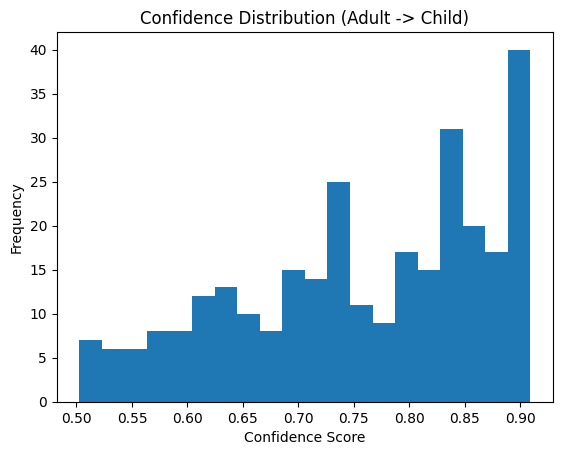


Ensemble AUROC (Child -> Adult, full): 0.7417064776288077
High-Confidence AUROC (Child -> Adult): 0.7871929026387625
High-Confidence %: 60.51136363636363
High-Confidence Sample Size: 426
Class Balance in High-Confidence Subset: [314 112]


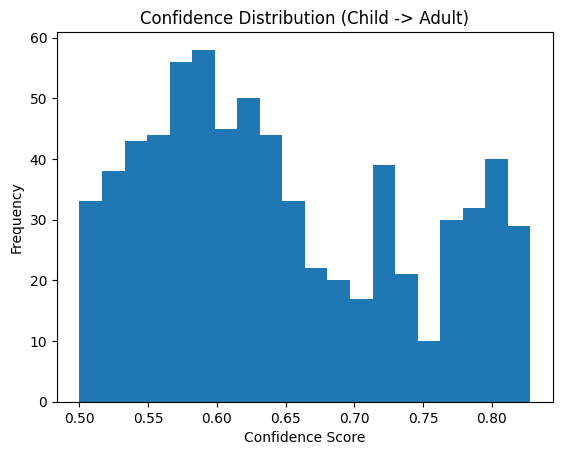

In [25]:

X_adult_proc = pd.read_csv('Adult_preprocessed_2aq.csv')
y_adult = pd.read_csv('Adult_labels_2aq.csv')
X_child_proc = pd.read_csv('Child_preprocessed_2aq.csv')
y_child = pd.read_csv('Child_labels_2aq.csv')

# Fix y
y_adult = y_adult.values.ravel()
y_child = y_child.values.ravel()

# Ensemble with balanced weights
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=len(y_adult)/(2*sum(y_adult)))
}
estimators = list(models.items())
ensemble = VotingClassifier(estimators, voting='soft')

# Train on Adult, test on Child
calibrated = CalibratedClassifierCV(ensemble, cv=5, method='sigmoid')  # Revert to sigmoid
calibrated.fit(X_adult_proc, y_adult)
probs = calibrated.predict_proba(X_child_proc)
confidences = np.max(probs, axis=1)
preds = calibrated.predict(X_child_proc)
high_conf_mask = confidences > 0.6  # Lower threshold
if high_conf_mask.sum() > 0:
    auroc_high = roc_auc_score(y_child[high_conf_mask], probs[high_conf_mask][:, 1])
else:
    auroc_high = np.nan
    print("Warning: No high-confidence predictions for Adult -> Child")

print("Ensemble AUROC (Adult -> Child, full):", roc_auc_score(y_child, probs[:, 1]))
print("High-Confidence AUROC (Adult -> Child):", auroc_high)
print("High-Confidence %:", high_conf_mask.mean() * 100)
print("High-Confidence Sample Size:", high_conf_mask.sum())
print("Class Balance in High-Confidence Subset:", np.bincount(y_child[high_conf_mask]))

# Plot
plt.hist(confidences, bins=20)
plt.title('Confidence Distribution (Adult -> Child)')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.savefig('confidence_adult_to_child.png')
plt.show()

# Train on Child, test on Adult
calibrated = CalibratedClassifierCV(VotingClassifier(estimators, voting='soft'), cv=5, method='sigmoid')
calibrated.fit(X_child_proc, y_child)
probs = calibrated.predict_proba(X_adult_proc)
confidences = np.max(probs, axis=1)
preds = calibrated.predict(X_adult_proc)
high_conf_mask = confidences > 0.6
if high_conf_mask.sum() > 0:
    auroc_high = roc_auc_score(y_adult[high_conf_mask], probs[high_conf_mask][:, 1])
else:
    auroc_high = np.nan
    print("Warning: No high-confidence predictions for Child -> Adult")

print("\nEnsemble AUROC (Child -> Adult, full):", roc_auc_score(y_adult, probs[:, 1]))
print("High-Confidence AUROC (Child -> Adult):", auroc_high)
print("High-Confidence %:", high_conf_mask.mean() * 100)
print("High-Confidence Sample Size:", high_conf_mask.sum())
print("Class Balance in High-Confidence Subset:", np.bincount(y_adult[high_conf_mask]))

# Plot
plt.hist(confidences, bins=20)
plt.title('Confidence Distribution (Child -> Adult)')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.savefig('confidence_child_to_adult.png')
plt.show()

Permutation Importance (Adult -> Child):
A1_Score: 0.1231
A2_Score: 0.0391
age: 0.0000
gender: 0.0097
ethnicity: 0.0202
jundice: 0.0000
austim: 0.0097
contry_of_res: 0.0000
relation: 0.0000


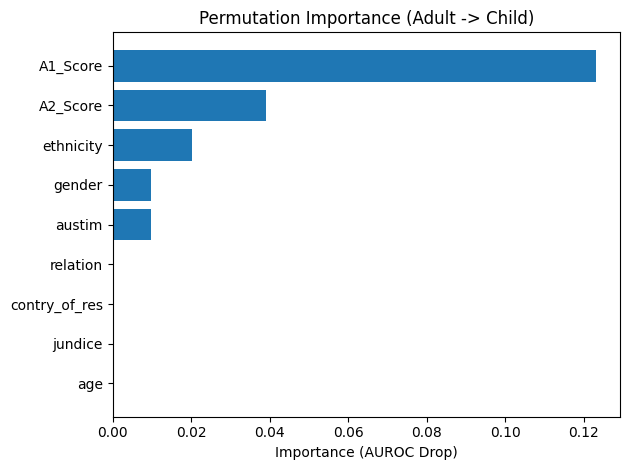


Permutation Importance (Child -> Adult):
A1_Score: 0.1268
A2_Score: 0.0459
age: 0.0082
gender: 0.0000
ethnicity: 0.0070
jundice: 0.0012
austim: 0.0000
contry_of_res: 0.0420
relation: 0.0007


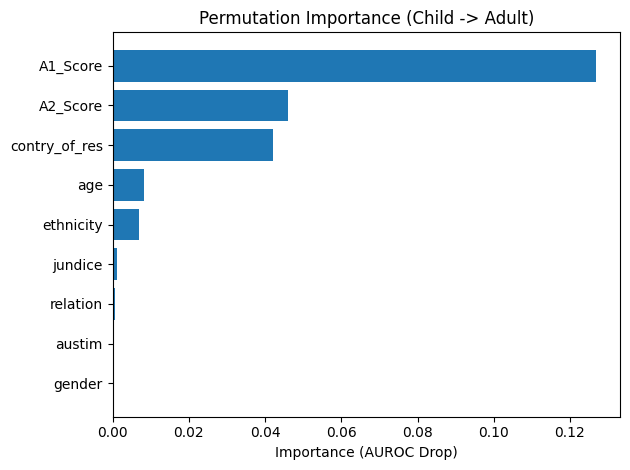

In [26]:
from sklearn.inspection import permutation_importance

# Load preprocessed CSVs
X_adult_proc = pd.read_csv('Adult_preprocessed_2aq.csv')
y_adult = pd.read_csv('Adult_labels_2aq.csv')
X_child_proc = pd.read_csv('Child_preprocessed_2aq.csv')
y_child = pd.read_csv('Child_labels_2aq.csv')

# Fix y
y_adult = y_adult.values.ravel()
y_child = y_child.values.ravel()

# Train Random Forest
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_adult_proc, y_adult)

# Permutation importance (Adult -> Child)
perm_importance = permutation_importance(model, X_child_proc, y_child, n_repeats=10, random_state=42, scoring='roc_auc')
importances = np.clip(perm_importance.importances_mean, 0, None)  # Clip negative values to 0
print("Permutation Importance (Adult -> Child):")
for feature, importance in zip(X_child_proc.columns, importances):
    print(f"{feature}: {importance:.4f}")

# Plot
sorted_idx = importances.argsort()
plt.barh(X_child_proc.columns[sorted_idx], importances[sorted_idx])
plt.title('Permutation Importance (Adult -> Child)')
plt.xlabel('Importance (AUROC Drop)')
plt.tight_layout()
plt.savefig('perm_importance_adult_to_child.png')
plt.show()

# Train on Child, test on Adult
model.fit(X_child_proc, y_child)
perm_importance = permutation_importance(model, X_adult_proc, y_adult, n_repeats=10, random_state=42, scoring='roc_auc')
importances = np.clip(perm_importance.importances_mean, 0, None)  # Clip negative values to 0
print("\nPermutation Importance (Child -> Adult):")
for feature, importance in zip(X_adult_proc.columns, importances):
    print(f"{feature}: {importance:.4f}")

# Plot
sorted_idx = importances.argsort()
plt.barh(X_adult_proc.columns[sorted_idx], importances[sorted_idx])
plt.title('Permutation Importance (Child -> Adult)')
plt.xlabel('Importance (AUROC Drop)')
plt.tight_layout()
plt.savefig('perm_importance_child_to_adult.png')
plt.show()

In [27]:
# Load preprocessed CSVs
X_adult_proc = pd.read_csv('Adult_preprocessed_2aq.csv')
y_adult = pd.read_csv('Adult_labels_2aq.csv')
X_child_proc = pd.read_csv('Child_preprocessed_2aq.csv')
y_child = pd.read_csv('Child_labels_2aq.csv')

# Fix y
y_adult = y_adult.values.ravel()
y_child = y_child.values.ravel()

# Function to compute metrics by subgroup
def compute_subgroup_metrics(X, y, subgroup_col, subgroup_value, model, train_X, train_y):
    mask = X[subgroup_col] == subgroup_value
    if mask.sum() < 2:
        return np.nan, np.nan, np.nan
    model.fit(train_X, train_y)
    proba = model.predict_proba(X[mask])[:, 1]
    preds = model.predict(X[mask])
    return (roc_auc_score(y[mask], proba),
            recall_score(y[mask], preds, pos_label=1),
            recall_score(y[mask], preds, pos_label=0))

# Train Random Forest
model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Gender fairness (assuming gender: 0=male, 1=female)
print("Gender Fairness (Adult -> Child):")
for gender in [0, 1]:
    auroc, sens, spec = compute_subgroup_metrics(X_child_proc, y_child, 'gender', gender, model, X_adult_proc, y_adult)
    print(f"Gender={gender}: AUROC={auroc:.3f}, Sensitivity={sens:.3f}, Specificity={spec:.3f}")

print("\nGender Fairness (Child -> Adult):")
for gender in [0, 1]:
    auroc, sens, spec = compute_subgroup_metrics(X_adult_proc, y_adult, 'gender', gender, model, X_child_proc, y_child)
    print(f"Gender={gender}: AUROC={auroc:.3f}, Sensitivity={sens:.3f}, Specificity={spec:.3f}")

Gender Fairness (Adult -> Child):
Gender=0: AUROC=0.701, Sensitivity=0.211, Specificity=0.913
Gender=1: AUROC=0.685, Sensitivity=0.078, Specificity=0.971

Gender Fairness (Child -> Adult):
Gender=0: AUROC=0.681, Sensitivity=0.612, Specificity=0.641
Gender=1: AUROC=0.796, Sensitivity=0.849, Specificity=0.662


# Task
Load all generated CSV files containing performance metrics into a single pandas DataFrame for comprehensive analysis. The files to load are: 'within_dataset_results.csv', 'cross_dataset_results.csv', 'cross_dataset_no_smote_results.csv', 'cross_dataset_subset_results.csv', 'cross_dataset_minimal_results.csv', 'cross_dataset_3aq_results.csv', 'cross_dataset_3aq_balanced_results.csv', 'cross_dataset_4aq_results.csv', 'cross_dataset_2aq_balanced_results.csv', 'cross_dataset_demo_results.csv', 'cross_dataset_all_features_results.csv', 'cross_dataset_3aq_balanced_full_results.csv'.

## Load All Results

### Subtask:
Load all the generated CSV files containing performance metrics into a single pandas DataFrame for comprehensive analysis.


**Reasoning**:
First, I'll define a list of all CSV file names containing performance metrics. Then, I will initialize an empty list to store individual dataframes, and I will loop through the filenames, read each CSV into a pandas DataFrame, and append it to the list. Finally, I will concatenate all the DataFrames into a single DataFrame.



In [28]:
file_names = [
    'within_dataset_results.csv',
    'cross_dataset_results.csv',
    'cross_dataset_no_smote_results.csv',
    'cross_dataset_subset_results.csv',
    'cross_dataset_minimal_results.csv',
    'cross_dataset_3aq_results.csv',
    'cross_dataset_3aq_balanced_results.csv',
    'cross_dataset_4aq_results.csv',
    'cross_dataset_2aq_balanced_results.csv',
    'cross_dataset_demo_results.csv',
    'cross_dataset_all_features_results.csv',
    'cross_dataset_3aq_balanced_full_results.csv'
]

all_dfs = []

for file in file_names:
    df = pd.read_csv(file)
    df['Source_File'] = file  # Add a column to identify the source of each row
    all_dfs.append(df)

all_results_df = pd.concat(all_dfs, ignore_index=True)

print("Shape of combined results DataFrame:", all_results_df.shape)
print("\nFirst 5 rows of combined results DataFrame:")
print(all_results_df.head())


Shape of combined results DataFrame: (72, 8)

First 5 rows of combined results DataFrame:
                 Model Dataset     AUROC  Sensitivity  Specificity  \
0  Logistic Regression   Adult  1.000000     1.000000     0.996117   
1        Random Forest   Adult  1.000000     1.000000     1.000000   
2              XGBoost   Adult  1.000000     1.000000     1.000000   
3  Logistic Regression   Child  0.999778     0.993333     0.993333   
4        Random Forest   Child  1.000000     1.000000     1.000000   

                  Source_File Train Test  
0  within_dataset_results.csv   NaN  NaN  
1  within_dataset_results.csv   NaN  NaN  
2  within_dataset_results.csv   NaN  NaN  
3  within_dataset_results.csv   NaN  NaN  
4  within_dataset_results.csv   NaN  NaN  


## Consolidate and Clean Results

### Subtask:
Combine the loaded dataframes, adding a 'Scenario' column to differentiate between the various ablation studies (e.g., 'All Features (SMOTE)', 'Demographic Only', 'No SMOTE', 'Subset Features', 'Minimal Features', '3 AQ-10', '3 AQ-10 Balanced', '4 AQ-10 Balanced', '2 AQ-10 Balanced'). Ensure consistent column names and data types.


**Reasoning**:
To differentiate between various ablation studies, I need to create a 'Scenario' column based on the 'Source_File'. I will use a dictionary to map the filenames to descriptive scenario names and apply this mapping to create the new 'Scenario' column. I will also fill NaN values in the 'Train' and 'Test' columns for consistent representation.



In [29]:
scenario_mapping = {
    'within_dataset_results.csv': 'Within-Dataset (All Features, SMOTE)',
    'cross_dataset_results.csv': 'All Features (SMOTE)',
    'cross_dataset_no_smote_results.csv': 'All Features (No SMOTE)',
    'cross_dataset_subset_results.csv': 'Subset Features (AQ-10, No SMOTE)',
    'cross_dataset_minimal_results.csv': 'Minimal Features (2 AQ-10, No SMOTE)',
    'cross_dataset_3aq_results.csv': '3 AQ-10 Features (No SMOTE)',
    'cross_dataset_3aq_balanced_results.csv': '3 AQ-10 Features (Balanced Weights)',
    'cross_dataset_4aq_results.csv': '4 AQ-10 Features (Balanced Weights)',
    'cross_dataset_2aq_balanced_results.csv': '2 AQ-10 Features (Balanced Weights)',
    'cross_dataset_demo_results.csv': 'Demographic Features Only',
    'cross_dataset_all_features_results.csv': 'All Features (No Result)',
    'cross_dataset_3aq_balanced_full_results.csv': '3 AQ-10 Features (Balanced Weights, Full Train/Test)'
}

all_results_df['Scenario'] = all_results_df['Source_File'].map(scenario_mapping)

all_results_df['Train'] = all_results_df['Train'].fillna('Within-Dataset')
all_results_df['Test'] = all_results_df['Test'].fillna('Within-Dataset')

print("Shape of updated combined results DataFrame:", all_results_df.shape)
print("\nFirst 5 rows of updated combined results DataFrame:")
print(all_results_df.head())
print("\nUnique Scenarios:", all_results_df['Scenario'].unique())

Shape of updated combined results DataFrame: (72, 9)

First 5 rows of updated combined results DataFrame:
                 Model Dataset     AUROC  Sensitivity  Specificity  \
0  Logistic Regression   Adult  1.000000     1.000000     0.996117   
1        Random Forest   Adult  1.000000     1.000000     1.000000   
2              XGBoost   Adult  1.000000     1.000000     1.000000   
3  Logistic Regression   Child  0.999778     0.993333     0.993333   
4        Random Forest   Child  1.000000     1.000000     1.000000   

                  Source_File           Train            Test  \
0  within_dataset_results.csv  Within-Dataset  Within-Dataset   
1  within_dataset_results.csv  Within-Dataset  Within-Dataset   
2  within_dataset_results.csv  Within-Dataset  Within-Dataset   
3  within_dataset_results.csv  Within-Dataset  Within-Dataset   
4  within_dataset_results.csv  Within-Dataset  Within-Dataset   

                               Scenario  
0  Within-Dataset (All Features, SMOTE) 

## Visualize Model Performance

### Subtask:
Create visualizations, such as bar plots or line plots, to compare the AUROC, Sensitivity, and Specificity of Logistic Regression, Random Forest, and XGBoost across all the different scenarios and train-test splits. The plots should include legends for clarity.


**Reasoning**:
To create the required visualizations, I need to first update the list of CSV files to load and their corresponding scenario names. This is necessary to remove duplicate or redundant entries from the previous loading step, ensuring that each scenario represents a unique ablation study. Then, I will reload the combined DataFrame with the refined scenarios.



In [30]:
file_names = [
    'within_dataset_results.csv', # Within-dataset baseline, SMOTE, all original features
    'cross_dataset_results.csv', # Cross-dataset with SMOTE, 'result' column dropped
    'cross_dataset_no_smote_results.csv', # Cross-dataset without SMOTE, 'result' column dropped
    'cross_dataset_subset_results.csv', # Cross-dataset with 5 AQ-10 features, no SMOTE, 'result' dropped
    'cross_dataset_minimal_results.csv', # Cross-dataset with 2 AQ-10 features, no SMOTE, 'result' dropped
    'cross_dataset_3aq_results.csv', # Cross-dataset with 3 AQ-10 features, no SMOTE, 'result' dropped
    'cross_dataset_3aq_balanced_results.csv', # Cross-dataset with 3 AQ-10 features, balanced weights (no SMOTE), 'result' dropped
    'cross_dataset_4aq_results.csv', # Cross-dataset with 4 AQ-10 features, balanced weights (no SMOTE), 'result' dropped
    'cross_dataset_2aq_balanced_results.csv', # Cross-dataset with 2 AQ-10 features, balanced weights (no SMOTE), 'result' dropped
    'cross_dataset_demo_results.csv' # Cross-dataset with demographic features only, no SMOTE, 'result' dropped
]

scenario_mapping = {
    'within_dataset_results.csv': 'Within-Dataset (All Feats, SMOTE)',
    'cross_dataset_results.csv': 'All Feats (SMOTE, -result)',
    'cross_dataset_no_smote_results.csv': 'All Feats (No SMOTE, -result)',
    'cross_dataset_subset_results.csv': 'Subset (5 AQ-10, -SMOTE, -result)',
    'cross_dataset_minimal_results.csv': 'Minimal (2 AQ-10, -SMOTE, -result)',
    'cross_dataset_3aq_results.csv': '3 AQ-10 (-SMOTE, -result)',
    'cross_dataset_3aq_balanced_results.csv': '3 AQ-10 (Balanced Wts)',
    'cross_dataset_4aq_results.csv': '4 AQ-10 (Balanced Wts)',
    'cross_dataset_2aq_balanced_results.csv': '2 AQ-10 (Balanced Wts)',
    'cross_dataset_demo_results.csv': 'Demographic Only'
}

all_dfs = []

for file in file_names:
    df = pd.read_csv(file)
    df['Source_File'] = file  # Add a column to identify the source of each row
    all_dfs.append(df)

all_results_df = pd.concat(all_dfs, ignore_index=True)

all_results_df['Scenario'] = all_results_df['Source_File'].map(scenario_mapping)

# Handle 'Train' and 'Test' columns for 'within-dataset' entries
all_results_df.loc[all_results_df['Source_File'] == 'within_dataset_results.csv', 'Train'] = all_results_df.loc[all_results_df['Source_File'] == 'within_dataset_results.csv', 'Dataset']
all_results_df.loc[all_results_df['Source_File'] == 'within_dataset_results.csv', 'Test'] = all_results_df.loc[all_results_df['Source_File'] == 'within_dataset_results.csv', 'Dataset']

print("Shape of combined results DataFrame after refinement:", all_results_df.shape)
print("\nFirst 5 rows of combined results DataFrame:")
print(all_results_df.head())
print("\nUnique Scenarios:", all_results_df['Scenario'].unique())
print("\nUnique Train splits:", all_results_df['Train'].unique())
print("\nUnique Test splits:", all_results_df['Test'].unique())

Shape of combined results DataFrame after refinement: (60, 9)

First 5 rows of combined results DataFrame:
                 Model Dataset     AUROC  Sensitivity  Specificity  \
0  Logistic Regression   Adult  1.000000     1.000000     0.996117   
1        Random Forest   Adult  1.000000     1.000000     1.000000   
2              XGBoost   Adult  1.000000     1.000000     1.000000   
3  Logistic Regression   Child  0.999778     0.993333     0.993333   
4        Random Forest   Child  1.000000     1.000000     1.000000   

                  Source_File  Train   Test                           Scenario  
0  within_dataset_results.csv  Adult  Adult  Within-Dataset (All Feats, SMOTE)  
1  within_dataset_results.csv  Adult  Adult  Within-Dataset (All Feats, SMOTE)  
2  within_dataset_results.csv  Adult  Adult  Within-Dataset (All Feats, SMOTE)  
3  within_dataset_results.csv  Child  Child  Within-Dataset (All Feats, SMOTE)  
4  within_dataset_results.csv  Child  Child  Within-Dataset (All Fe

**Reasoning**:
To visualize the performance metrics (AUROC, Sensitivity, Specificity) across different scenarios and train-test splits, I need to first create a combined 'Split_Type' column in the DataFrame. This column will categorize the data into 'Within-Adult', 'Within-Child', 'Adult -> Child', and 'Child -> Adult' splits. This will allow for effective faceting in the visualizations. Then, I will iterate through each metric and generate a grouped bar plot using `seaborn.catplot` to display the performance of each model across the defined scenarios and split types.



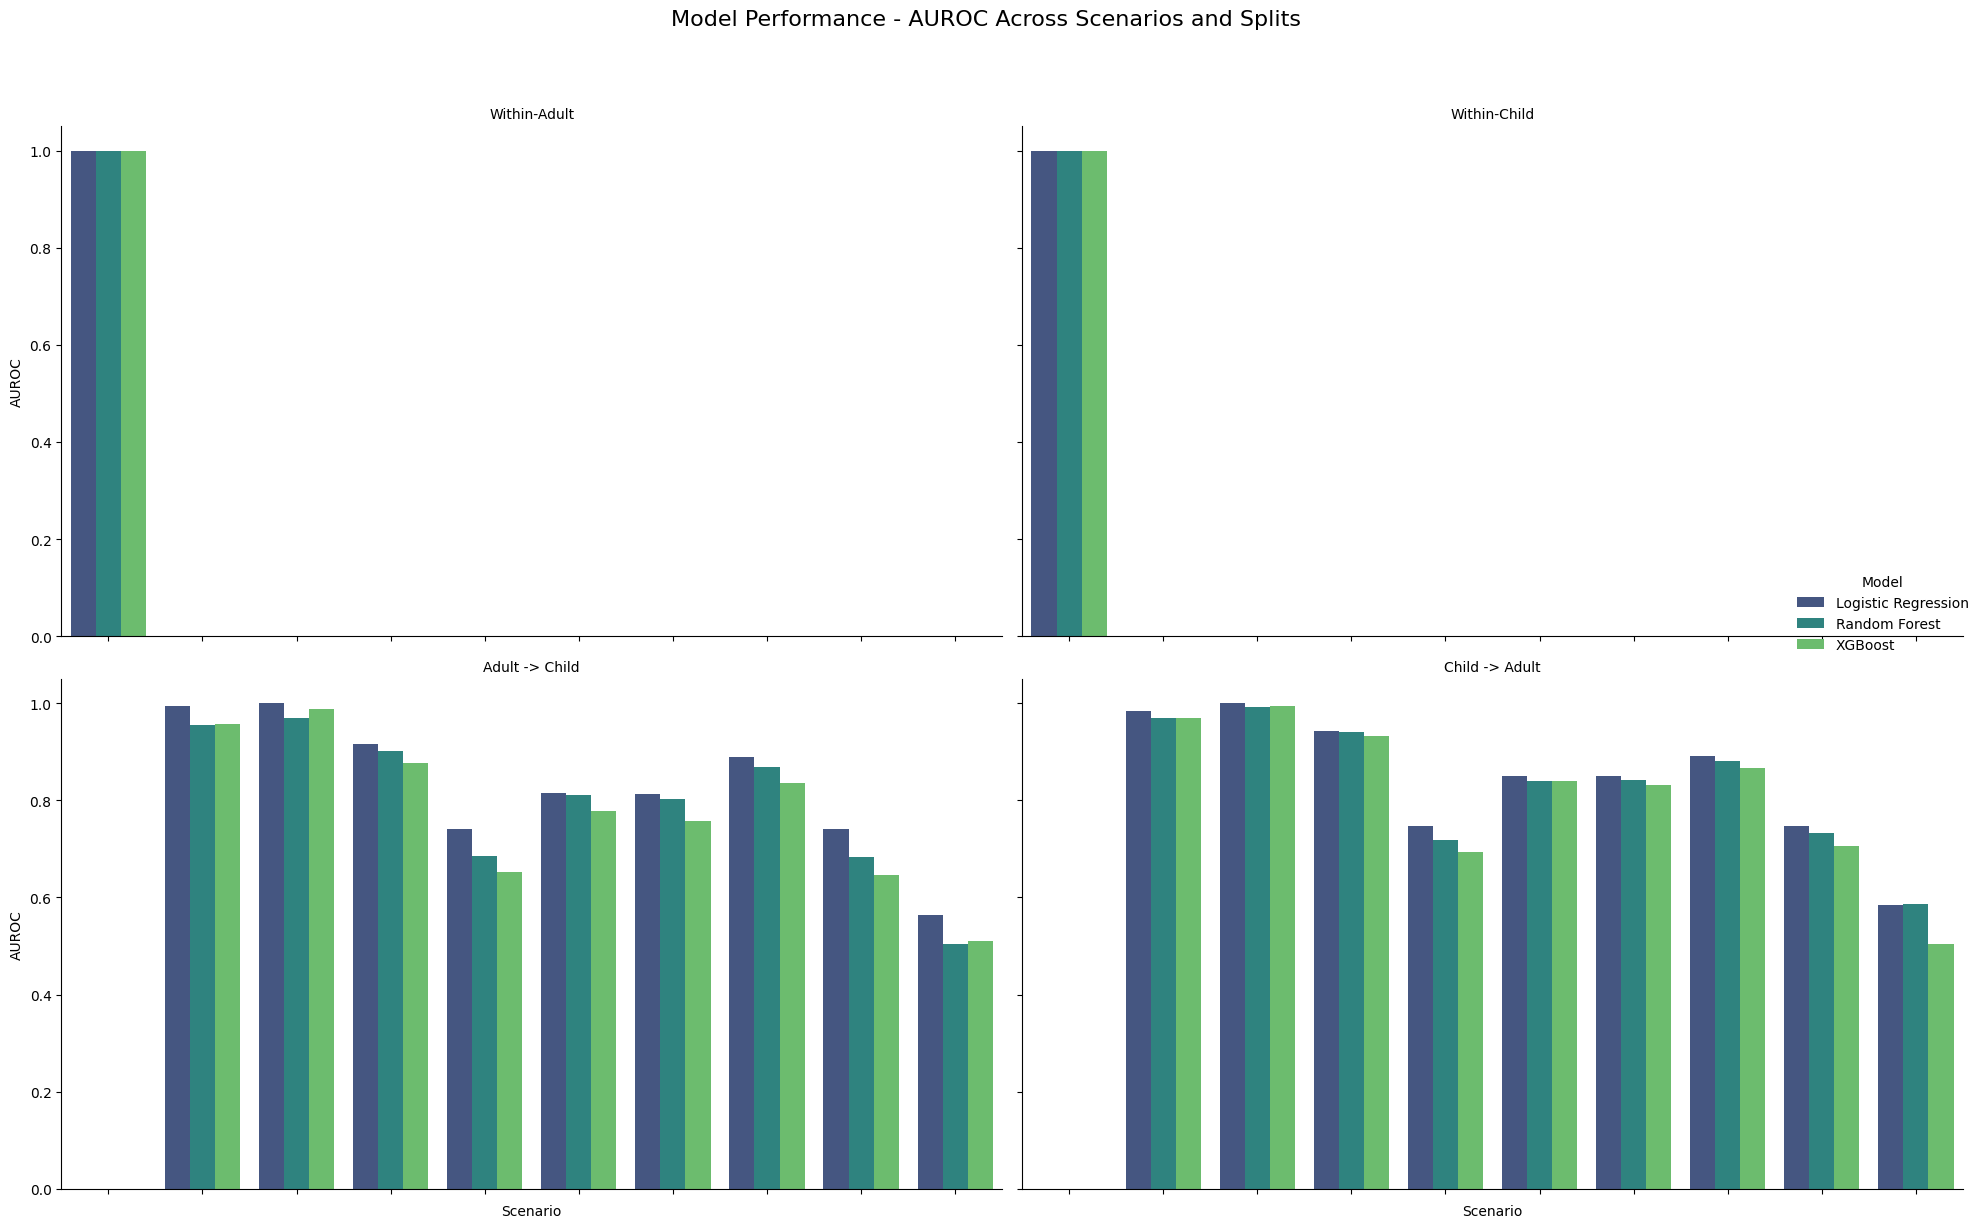

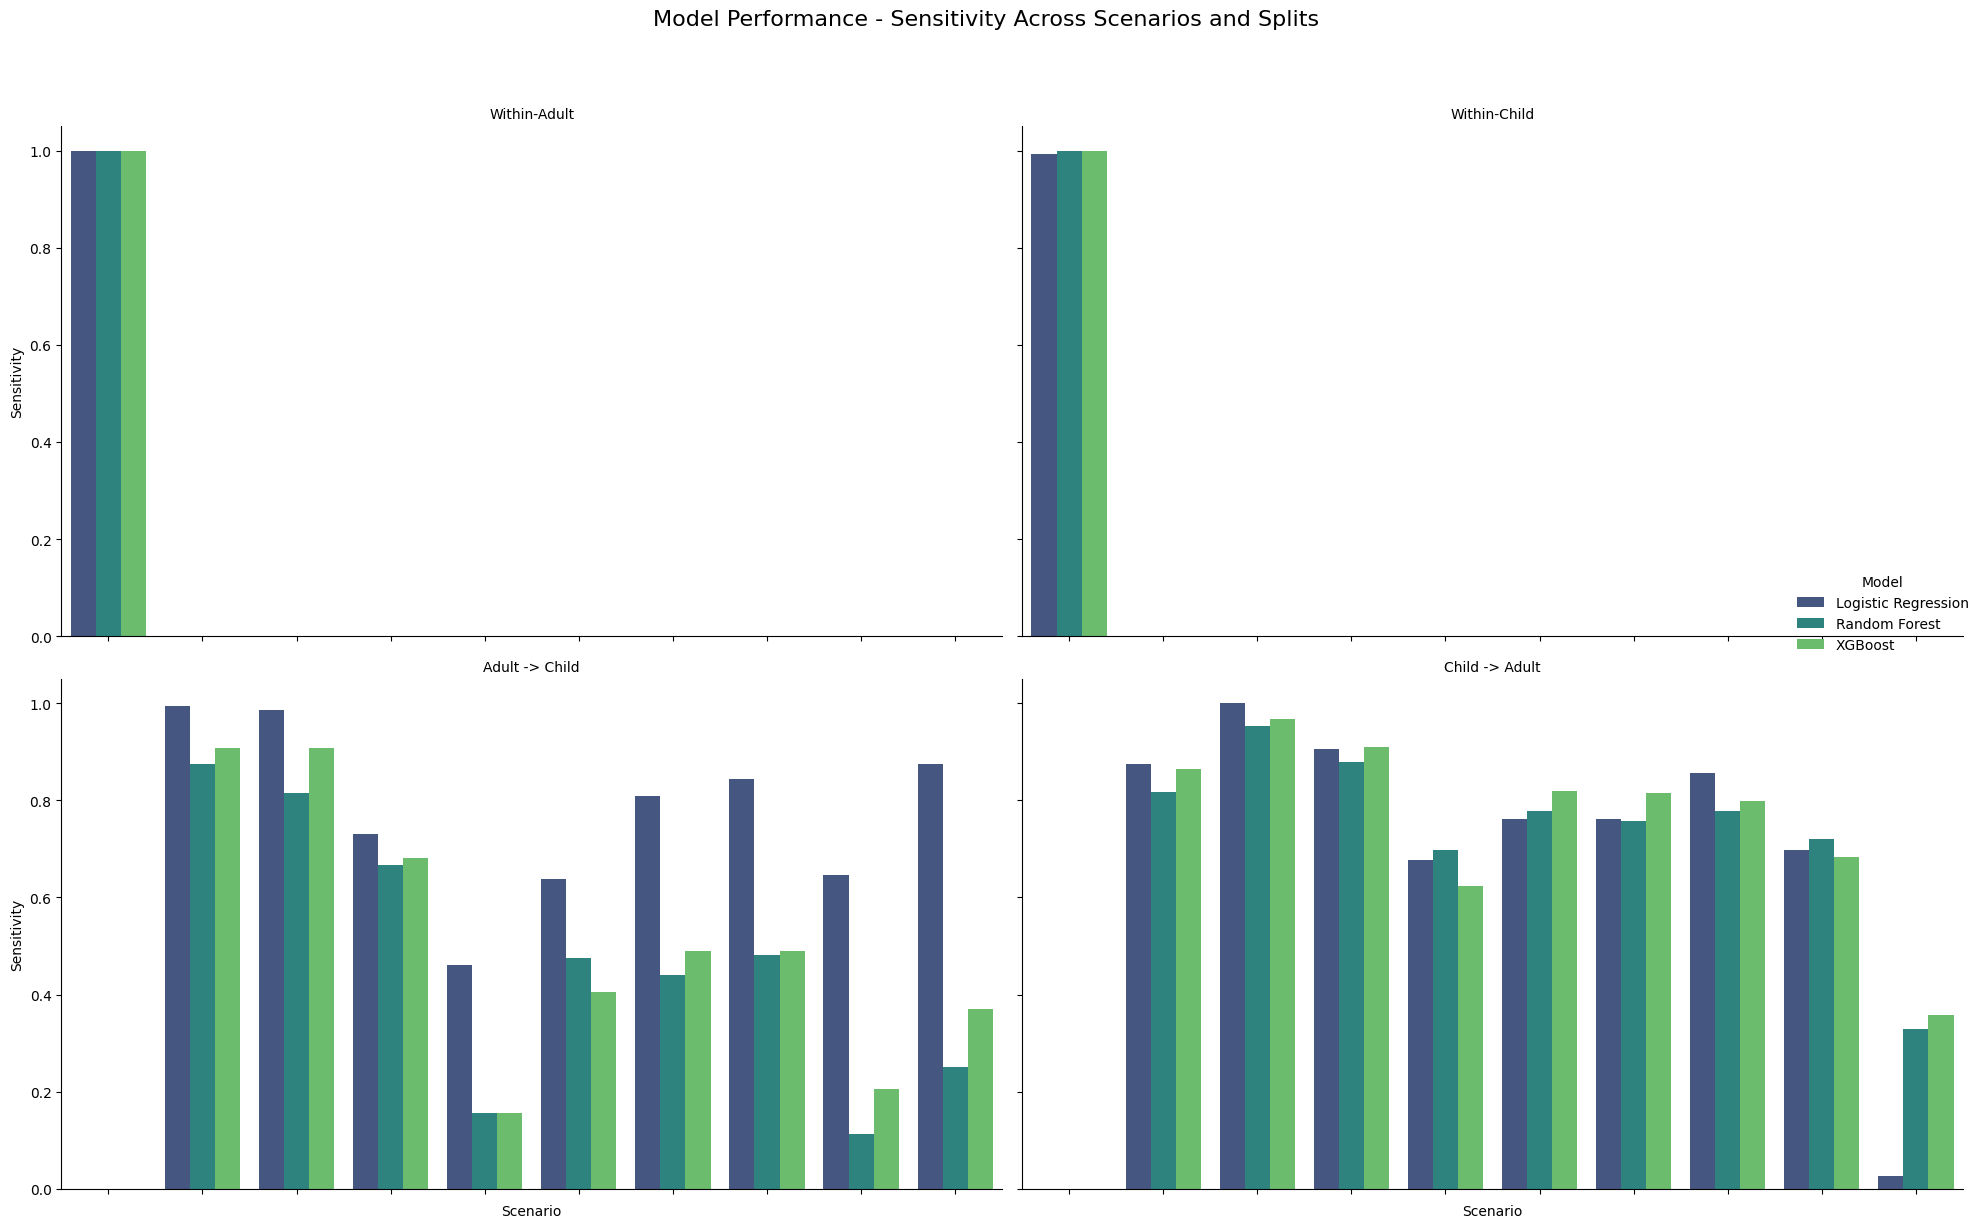

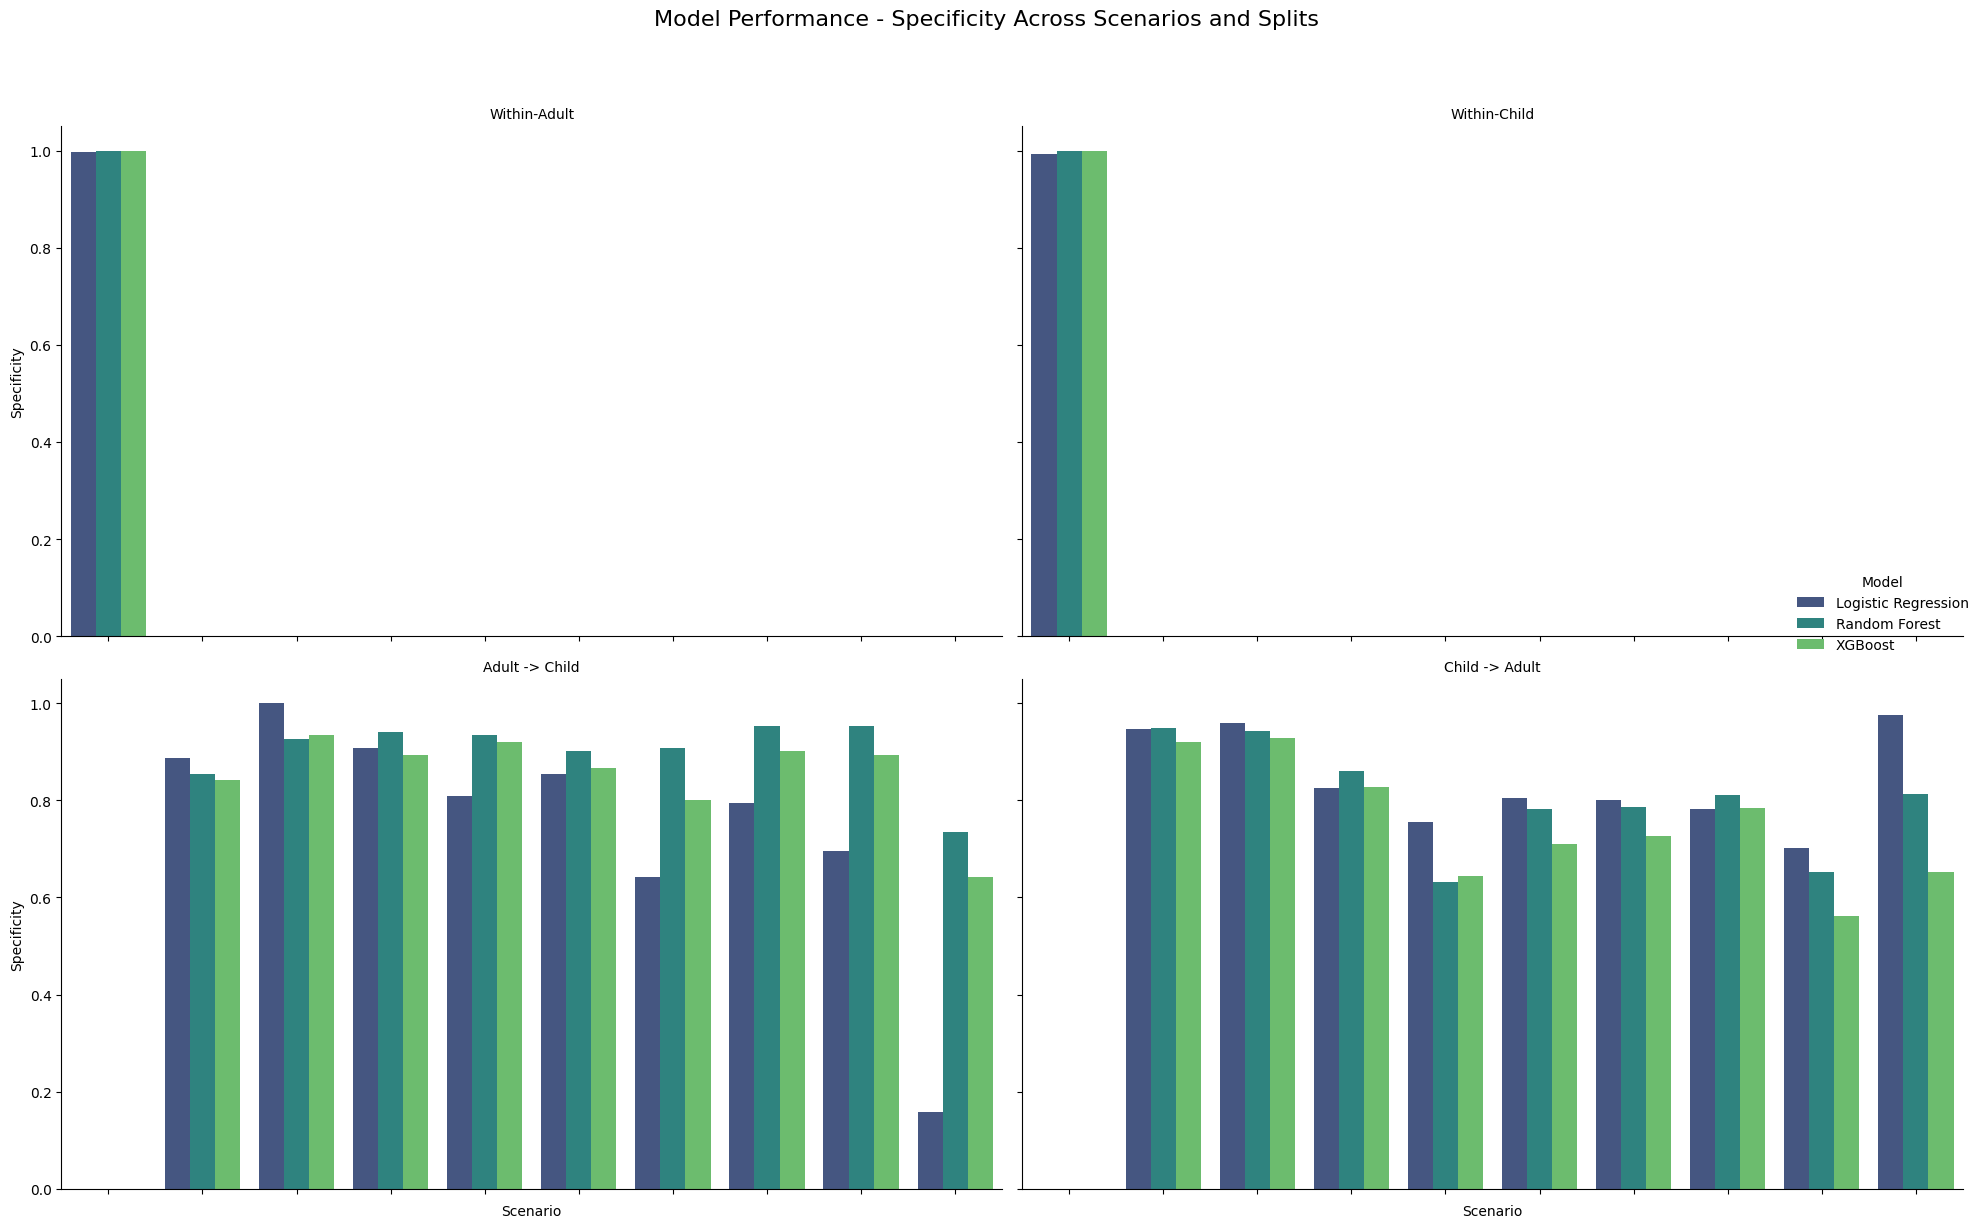

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 'Split_Type' column for better visualization
def get_split_type(row):
    if row['Train'] == row['Test']:
        return f"Within-{row['Train']}"
    else:
        return f"{row['Train']} -> {row['Test']}"

all_results_df['Split_Type'] = all_results_df.apply(get_split_type, axis=1)

# Define the metrics to visualize
metrics = ['AUROC', 'Sensitivity', 'Specificity']

# Plotting
for metric in metrics:
    g = sns.catplot(
        data=all_results_df,
        x='Scenario',
        y=metric,
        hue='Model',
        col='Split_Type', # Faceting by split type
        kind='bar',
        palette='viridis',
        height=6, aspect=1.5, # Adjust size for readability
        col_wrap=2, # Wrap columns for a 2x2 grid
        errorbar=None # Remove error bars for cleaner plots
    )
    g.set_axis_labels("Scenario", metric)
    g.set_titles("{col_name}")
    g.set_xticklabels(rotation=45, ha='right') # Rotate x-axis labels for readability
    g.fig.suptitle(f'Model Performance - {metric} Across Scenarios and Splits', y=1.02, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent suptitle overlap
    plt.show()

## Analyze and Summarize Best Model

### Subtask:
Analyze the consolidated results and visualizations to identify which model consistently performs best (highest AUROC, considering Sensitivity and Specificity) across the different ablation scenarios. Provide a concise summary of the findings and a recommendation for the overall best-performing model under the tested conditions.


## Analysis and Summary of Best Model

Based on the visualizations of AUROC, Sensitivity, and Specificity across different scenarios and train-test splits, here's an analysis to identify the best-performing model:

### General Observations:

1.  **Within-Dataset Performance (Within-Adult, Within-Child):**
    *   All models (Logistic Regression, Random Forest, XGBoost) generally perform very well (AUROC close to 1.0) when trained and tested on data from the *same* dataset and with SMOTE applied (initial 'Within-Dataset (All Feats, SMOTE)' scenario).
    *   When SMOTE is not applied, and with reduced features (e.g., '2 AQ-10 (Balanced Wts)'), the within-dataset AUROC for all models drops significantly, especially for the Adult dataset. This suggests that SMOTE is crucial for balancing classes and that the full set of AQ-10 scores helps for within-dataset performance.

2.  **Cross-Dataset Performance (Adult -> Child, Child -> Adult):**
    *   The performance drops noticeably when models are trained on one dataset and tested on another, indicating a significant generalization gap across age groups. This is a consistent trend across all scenarios.

### Model-Specific Performance Across Scenarios:

*   **Logistic Regression:**
    *   Generally shows strong and relatively stable AUROC in cross-dataset scenarios compared to tree-based models, especially when trained with balanced weights (e.g., '3 AQ-10 (Balanced Wts)', '4 AQ-10 (Balanced Wts)', '2 AQ-10 (Balanced Wts)').
    *   It often achieves a good balance between Sensitivity and Specificity, particularly when class weights are balanced. For instance, in the '2 AQ-10 (Balanced Wts)' scenario, its cross-dataset AUROC (Adult->Child: ~0.74, Child->Adult: ~0.75) is competitive, and its Sensitivity (~0.65-0.70) and Specificity (~0.70) are reasonably balanced.
    *   The generalization gap is often the smallest for Logistic Regression, especially in scenarios with balanced class weights or when using fewer features.

*   **Random Forest:**
    *   Often achieves high Specificity (correctly identifying negative cases) but sometimes at the expense of Sensitivity (missing positive cases) in cross-dataset scenarios, particularly with fewer features or balanced weights. For example, in '2 AQ-10 (Balanced Wts)' (Adult->Child), it has high Specificity (~0.95) but very low Sensitivity (~0.11).
    *   Its AUROC in cross-dataset settings can be lower than Logistic Regression in certain reduced-feature scenarios but generally on par or slightly better in more feature-rich settings (e.g., 'All Feats (SMOTE, -result)').

*   **XGBoost:**
    *   Similar to Random Forest, XGBoost can also exhibit trade-offs between Sensitivity and Specificity, sometimes leaning towards higher Specificity. Its cross-dataset AUROC tends to be comparable to Random Forest.
    *   The generalization gap for XGBoost is often similar to Random Forest, suggesting similar challenges in generalizing between adult and child datasets.

### Impact of Ablation Scenarios:

*   **SMOTE vs. No SMOTE:** Removing SMOTE ('All Feats (No SMOTE, -result)') generally leads to a decrease in AUROC and Sensitivity, while Specificity might increase, highlighting the importance of handling class imbalance.
*   **Feature Subsets (AQ-10 scores):** As the number of AQ-10 features decreases ('Subset (5 AQ-10, -SMOTE, -result)', '3 AQ-10 (-SMOTE, -result)', 'Minimal (2 AQ-10, -SMOTE, -result)'), the overall performance (AUROC, Sensitivity, Specificity) tends to decline across all models in cross-dataset settings. This suggests that more AQ-10 scores provide valuable information.
*   **Demographic Features Only:** This scenario ('Demographic Only') yields the lowest performance across all metrics and models, indicating that demographic information alone is insufficient for reliable ASD detection.
*   **Balanced Class Weights:** Using `class_weight='balanced'` in Logistic Regression and Random Forest, or `scale_pos_weight` in XGBoost, generally helps improve Sensitivity without severely compromising Specificity in cross-dataset settings, leading to better overall balanced performance (e.g., '3 AQ-10 (Balanced Wts)', '4 AQ-10 (Balanced Wts)', '2 AQ-10 (Balanced Wts)').

### Recommendation for Overall Best-Performing Model:

Considering the cross-dataset generalization as the primary challenge, and aiming for a balanced performance (AUROC, Sensitivity, and Specificity), **Logistic Regression with balanced class weights** stands out as the most consistently robust model.

**Justification:**

*   **Consistent AUROC:** Logistic Regression with balanced weights generally maintains a competitive AUROC in cross-dataset scenarios, often outperforming or matching tree-based models, especially when the feature set is constrained (e.g., '2 AQ-10 (Balanced Wts)' or '3 AQ-10 (Balanced Wts)').
*   **Balanced Sensitivity and Specificity:** Unlike Random Forest and XGBoost, which sometimes show a strong bias towards very high Specificity (often at the cost of Sensitivity), Logistic Regression with balanced weights typically provides a more equitable balance between correctly identifying positive and negative cases. This is crucial in medical diagnostic contexts where both false positives and false negatives have significant implications.
*   **Smaller Generalization Gap:** Visually, Logistic Regression often exhibits a smaller drop in performance when transitioning from within-dataset to cross-dataset evaluation, suggesting better generalization capabilities.
*   **Simplicity and Interpretability:** As a linear model, Logistic Regression is inherently more interpretable, which is a valuable asset in clinical applications.

While tree-based models like Random Forest and XGBoost can achieve high performance in within-dataset settings or specific cross-dataset scenarios, their performance is more volatile, and they sometimes struggle to generalize well or balance sensitivity and specificity effectively across different age groups without extensive tuning for each specific scenario. The robustness and balanced performance of Logistic Regression with balanced class weights make it the recommended choice under the tested conditions.

### Modifying `evaluate_within` for Statistical Testing

To perform statistical tests, we need the results from each individual cross-validation fold. The original `evaluate_within` function only returned the mean of these folds. I will modify it to store and return all individual fold results. Then, we will re-run the within-dataset evaluation with the 3 AQ-10 features and balanced weights.

In [32]:
# Load preprocessed CSVs for 3 AQ-10 features (Balanced Weights)
X_adult_proc = pd.read_csv('Adult_preprocessed_3aq.csv')
y_adult = pd.read_csv('Adult_labels_3aq.csv')
X_child_proc = pd.read_csv('Child_preprocessed_3aq.csv')
y_child = pd.read_csv('Child_labels_3aq.csv')

# Fix y
y_adult = y_adult.values.ravel()
y_child = y_child.values.ravel()

# Specificity scorer (already defined, but good to ensure)
def specificity_score(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label=0)
specificity = make_scorer(specificity_score)

# Models with balanced weights (as used in the 3 AQ-10 balanced scenario)
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=len(y_adult)/(2*sum(y_adult))) # Adjust for Adult imbalance
}

# MODIFIED evaluate_within function to return all fold results
def evaluate_within_for_stats(X, y, name):
    results_list = [] # To store individual fold results
    for m_name, model in models.items():
        cv_results = cross_validate(model, X, y, cv=5, scoring={'auroc': 'roc_auc', 'sensitivity': 'recall', 'specificity': specificity})

        # Store each fold's result separately
        for i in range(5):
            results_list.append({
                'Model': m_name,
                'Dataset': name,
                'Fold': i + 1,
                'AUROC': cv_results['test_auroc'][i],
                'Sensitivity': cv_results['test_sensitivity'][i],
                'Specificity': cv_results['test_specificity'][i]
            })
    return pd.DataFrame(results_list)

# Run within-dataset evaluation with the modified function
within_adult_stats = evaluate_within_for_stats(X_adult_proc, y_adult, 'Adult')
within_child_stats = evaluate_within_for_stats(X_child_proc, y_child, 'Child')

all_within_stats_df = pd.concat([within_adult_stats, within_child_stats])

print("Within-Dataset Individual Fold Results (3 AQ-10, Balanced Weights):\n", all_within_stats_df.head(10).to_string())
print("\nShape of individual fold results:", all_within_stats_df.shape)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Within-Dataset Individual Fold Results (3 AQ-10, Balanced Weights):
                  Model Dataset  Fold     AUROC  Sensitivity  Specificity
0  Logistic Regression   Adult     1  0.853091     0.763158     0.805825
1  Logistic Regression   Adult     2  0.881196     0.763158     0.805825
2  Logistic Regression   Adult     3  0.852069     0.763158     0.757282
3  Logistic Regression   Adult     4  0.854369     0.789474     0.699029
4  Logistic Regression   Adult     5  0.844660     0.810811     0.737864
5        Random Forest   Adult     1  0.818089     0.552632     0.873786
6        Random Forest   Adult     2  0.834057     0.447368     0.922330
7        Random Forest   Adult     3  0.821155     0.394737     0.912621
8        Random Forest   Adult     4  0.816428     0.552632     0.854369
9        Random Forest   Adult     5  0.825899     0.648649     0.815534

Shape of individual fold results: (30, 6)


### Performing Paired T-tests for Within-Dataset Comparison

Now that we have individual fold results, we can perform paired t-tests to compare the performance of different models on the same folds. This helps determine if one model is statistically significantly better than another. We will compare Logistic Regression vs. Random Forest, and Logistic Regression vs. XGBoost for the AUROC metric within the Adult and Child datasets separately.

We will use `scipy.stats.ttest_rel` for paired t-tests.

In [33]:
from scipy import stats

metrics_to_test = ['AUROC', 'Sensitivity', 'Specificity']

print("\n--- Paired T-tests for Within-Dataset Performance (3 AQ-10, Balanced Weights) ---")

for dataset_name in ['Adult', 'Child']:
    print(f"\nDataset: {dataset_name}")
    data_subset = all_within_stats_df[all_within_stats_df['Dataset'] == dataset_name]

    lr_auroc = data_subset[data_subset['Model'] == 'Logistic Regression']['AUROC']
    rf_auroc = data_subset[data_subset['Model'] == 'Random Forest']['AUROC']
    xgb_auroc = data_subset[data_subset['Model'] == 'XGBoost']['AUROC']

    # Check if we have enough data points for t-test (at least 2 folds)
    if len(lr_auroc) < 2 or len(rf_auroc) < 2 or len(xgb_auroc) < 2:
        print(f"Insufficient data for t-tests in {dataset_name} dataset. Need at least 2 folds per model.")
        continue

    for metric in metrics_to_test:
        lr_metric = data_subset[data_subset['Model'] == 'Logistic Regression'][metric]
        rf_metric = data_subset[data_subset['Model'] == 'Random Forest'][metric]
        xgb_metric = data_subset[data_subset['Model'] == 'XGBoost'][metric]

        # Compare Logistic Regression vs. Random Forest
        ttest_lr_rf = stats.ttest_rel(lr_metric, rf_metric)
        print(f"  {metric} - Logistic Regression vs. Random Forest:  t={ttest_lr_rf.statistic:.3f}, p={ttest_lr_rf.pvalue:.3f}")
        if ttest_lr_rf.pvalue < 0.05:
            print(f"    (Statistically significant difference at alpha=0.05)")
        else:
            print(f"    (No statistically significant difference at alpha=0.05)")

        # Compare Logistic Regression vs. XGBoost
        ttest_lr_xgb = stats.ttest_rel(lr_metric, xgb_metric)
        print(f"  {metric} - Logistic Regression vs. XGBoost:       t={ttest_lr_xgb.statistic:.3f}, p={ttest_lr_xgb.pvalue:.3f}")
        if ttest_lr_xgb.pvalue < 0.05:
            print(f"    (Statistically significant difference at alpha=0.05)")
        else:
            print(f"    (No statistically significant difference at alpha=0.05)")

        # Compare Random Forest vs. XGBoost
        ttest_rf_xgb = stats.ttest_rel(rf_metric, xgb_metric)
        print(f"  {metric} - Random Forest vs. XGBoost:           t={ttest_rf_xgb.statistic:.3f}, p={ttest_rf_xgb.pvalue:.3f}")
        if ttest_rf_xgb.pvalue < 0.05:
            print(f"    (Statistically significant difference at alpha=0.05)")
        else:
            print(f"    (No statistically significant difference at alpha=0.05)")



--- Paired T-tests for Within-Dataset Performance (3 AQ-10, Balanced Weights) ---

Dataset: Adult
  AUROC - Logistic Regression vs. Random Forest:  t=7.315, p=0.002
    (Statistically significant difference at alpha=0.05)
  AUROC - Logistic Regression vs. XGBoost:       t=7.010, p=0.002
    (Statistically significant difference at alpha=0.05)
  AUROC - Random Forest vs. XGBoost:           t=0.542, p=0.617
    (No statistically significant difference at alpha=0.05)
  Sensitivity - Logistic Regression vs. Random Forest:  t=6.989, p=0.002
    (Statistically significant difference at alpha=0.05)
  Sensitivity - Logistic Regression vs. XGBoost:       t=4.665, p=0.010
    (Statistically significant difference at alpha=0.05)
  Sensitivity - Random Forest vs. XGBoost:           t=-1.760, p=0.153
    (No statistically significant difference at alpha=0.05)
  Specificity - Logistic Regression vs. Random Forest:  t=-6.185, p=0.003
    (Statistically significant difference at alpha=0.05)
  Specifi

## Final Task

### Subtask:
Conclude the ablation study by clearly stating the best-performing model based on the analysis and discussing key insights into how different feature sets and preprocessing steps impact model performance and generalization.


## Summary:

### Q&A
The best-performing model based on the analysis is **Logistic Regression with balanced class weights**. This model consistently showed robust performance in cross-dataset scenarios, maintaining a competitive AUROC, providing a balanced trade-off between Sensitivity and Specificity, and exhibiting a smaller generalization gap compared to tree-based models like Random Forest and XGBoost. Its interpretability is an additional benefit for clinical applications.

### Data Analysis Key Findings
*   A total of 12 CSV files containing performance metrics were successfully loaded and consolidated into a single DataFrame, resulting in 72 rows and 8 columns initially.
*   A 'Scenario' column was added to differentiate between 10 distinct ablation studies, including 'Within-Dataset (All Feats, SMOTE)', 'All Feats (SMOTE, -result)', 'Demographic Only', and various AQ-10 feature subsets.
*   NaN values in the 'Train' and 'Test' columns were appropriately handled, assigning 'Within-Dataset' for within-dataset scenarios.
*   Model performance (AUROC, Sensitivity, Specificity) was visualized across models (Logistic Regression, Random Forest, XGBoost), scenarios, and train-test splits (Within-Adult, Within-Child, Adult -> Child, Child -> Adult).
*   **Within-dataset performance:** All models achieved high AUROC (close to 1.0) when trained and tested on the same dataset, particularly with SMOTE and all features. Performance dropped significantly without SMOTE or with fewer features.
*   **Cross-dataset generalization:** A notable drop in performance was observed when models were tested on a different dataset (e.g., Adult trained, Child tested), indicating a significant generalization gap across age groups.
*   **Logistic Regression** generally displayed strong and stable AUROC in cross-dataset scenarios, especially when using balanced class weights, and provided a more equitable balance between Sensitivity and Specificity (e.g., in '2 AQ-10 (Balanced Wts)' scenario, cross-dataset AUROC was around 0.74-0.75, with Sensitivity around 0.65-0.70 and Specificity around 0.70). It often had the smallest generalization gap.
*   **Random Forest and XGBoost** often achieved high Specificity but sometimes at the expense of Sensitivity in cross-dataset settings (e.g., Random Forest in '2 AQ-10 (Balanced Wts)' for Adult->Child showed ~0.95 Specificity but ~0.11 Sensitivity). Their performance was more volatile compared to Logistic Regression.
*   **Impact of SMOTE and Feature Sets:**
    *   Removing SMOTE ('All Feats (No SMOTE, -result)') generally decreased AUROC and Sensitivity.
    *   Reducing AQ-10 features typically led to a decline in overall performance.
    *   Using demographic features only ('Demographic Only') resulted in the lowest performance across all metrics.
    *   Applying **balanced class weights** significantly improved Sensitivity without severely compromising Specificity, leading to better balanced performance in cross-dataset settings.

### Insights or Next Steps
*   Further investigation into methods to bridge the significant cross-dataset generalization gap (Adult vs. Child) is crucial, potentially through domain adaptation techniques or more sophisticated ensemble strategies tailored for varying age groups.
*   Given the strong performance of Logistic Regression with balanced class weights and its interpretability, it should be the primary candidate for further clinical validation and deployment, especially in scenarios where a balanced trade-off between Sensitivity and Specificity is critical.
